In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


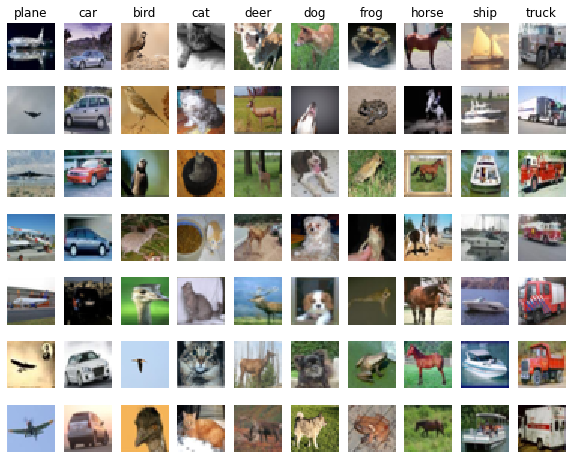

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


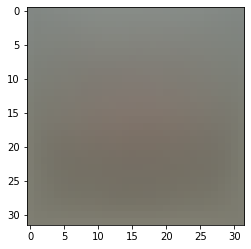

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [14]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

[autoreload of cs231n.classifiers.linear_svm failed: Traceback (most recent call last):
  File "/Users/liuhengyu/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/liuhengyu/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/liuhengyu/opt/anaconda3/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/liuhengyu/opt/anaconda3/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_w

IndexError: tuple index out of range

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [19]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 18.507145 analytic: 18.507145, relative error: 1.281699e-11
numerical: 18.154113 analytic: 18.154113, relative error: 1.422055e-11
numerical: -5.249538 analytic: -5.249538, relative error: 6.410277e-11
numerical: -12.328623 analytic: -12.328623, relative error: 2.831127e-11
numerical: 36.722976 analytic: 36.722976, relative error: 1.478417e-11
numerical: -10.130969 analytic: -10.130969, relative error: 3.824913e-11
numerical: 41.471079 analytic: 41.471079, relative error: 3.425834e-12
numerical: 14.781049 analytic: 14.781049, relative error: 3.781785e-11
numerical: -26.570275 analytic: -26.570275, relative error: 4.924877e-12
numerical: 10.889920 analytic: 10.889920, relative error: 2.775158e-11
numerical: 30.529794 analytic: 30.529794, relative error: 3.129970e-12
numerical: 16.022621 analytic: 16.022621, relative error: 1.652806e-11
numerical: 0.766887 analytic: 0.766887, relative error: 4.010665e-10
numerical: 15.501679 analytic: 15.501679, relative error: 1.224981e-13
nu

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [33]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.909371e+00 computed in 0.084175s
[[1.16130087 1.24529583 1.2132019  ... 0.90512799 1.33292773 0.86615938]
 [1.14262637 0.23772308 0.         ... 1.75764886 1.23613294 1.27953637]
 [1.03759653 0.37801956 1.38932126 ... 0.53444945 0.         1.01968369]
 ...
 [1.42052652 1.21405984 1.83586077 ... 1.3463917  1.59379345 1.09060079]
 [1.34847978 1.66622651 1.63553921 ... 1.32490115 1.21070077 0.92391548]
 [1.00508355 0.         0.45248122 ... 0.         0.79189842 0.99233246]]
Vectorized loss: 8.909371e+00 computed in 0.003120s
difference: -0.000000


In [37]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.089323s
4382.0
Vectorized loss and gradient: computed in 0.005933s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [74]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

1029.0
iteration 0 / 1500: loss 790.741624
1023.0
1096.0
1057.0
999.0
1042.0
1027.0
992.0
992.0
1013.0
956.0
1042.0
998.0
999.0
1096.0
918.0
996.0
1018.0
1032.0
931.0
986.0
916.0
981.0
924.0
922.0
990.0
1010.0
966.0
998.0
1065.0
950.0
962.0
1010.0
953.0
949.0
961.0
918.0
972.0
1053.0
1036.0
934.0
964.0
1051.0
951.0
974.0
944.0
924.0
925.0
975.0
936.0
1023.0
934.0
933.0
908.0
998.0
844.0
910.0
906.0
969.0
992.0
916.0
964.0
917.0
970.0
978.0
868.0
940.0
899.0
996.0
1011.0
983.0
835.0
1007.0
983.0
1000.0
913.0
946.0
980.0
975.0
836.0
907.0
962.0
981.0
966.0
969.0
1005.0
980.0
844.0
942.0
944.0
916.0
980.0
900.0
951.0
822.0
908.0
919.0
922.0
1005.0
920.0
937.0
iteration 100 / 1500: loss 287.906730
999.0
1005.0
909.0
921.0
991.0
962.0
955.0
924.0
969.0
993.0
925.0
931.0
993.0
861.0
885.0
962.0
955.0
1003.0
1037.0
1018.0
871.0
953.0
964.0
970.0
916.0
999.0
929.0
1008.0
954.0
931.0
999.0
995.0
1048.0
987.0
994.0
1054.0
983.0
969.0
950.0
990.0
973.0
945.0
971.0
949.0
995.0
1001.0
996.0
992.0
1

1170.0
1116.0
1122.0
1210.0
1154.0
1114.0
iteration 1200 / 1500: loss 4.973758
1087.0
1127.0
1110.0
1174.0
1191.0
1062.0
1125.0
1069.0
1096.0
1155.0
1101.0
1099.0
1146.0
1076.0
1147.0
1140.0
1130.0
1108.0
1144.0
1163.0
1138.0
1178.0
1123.0
1172.0
1149.0
1143.0
1122.0
1063.0
1084.0
1071.0
1104.0
1152.0
1110.0
1071.0
1117.0
1094.0
1113.0
1117.0
1067.0
1099.0
1118.0
1104.0
1112.0
1190.0
1118.0
1167.0
1079.0
1117.0
1166.0
1085.0
1065.0
1154.0
1077.0
1077.0
1116.0
1147.0
1151.0
1191.0
1153.0
1134.0
1130.0
1151.0
1104.0
1116.0
1038.0
1170.0
1134.0
1113.0
1126.0
1153.0
1121.0
1086.0
1145.0
1193.0
1093.0
1137.0
1148.0
1100.0
1152.0
1183.0
1175.0
1091.0
1155.0
1091.0
1079.0
1065.0
1135.0
1076.0
1058.0
1123.0
1095.0
1150.0
1180.0
1139.0
1159.0
1162.0
1127.0
1113.0
1134.0
1057.0
iteration 1300 / 1500: loss 4.944189
1103.0
1127.0
1177.0
1078.0
1092.0
1104.0
1038.0
1144.0
1186.0
1178.0
1154.0
1147.0
1098.0
1138.0
1129.0
1228.0
1202.0
1190.0
1079.0
1072.0
1157.0
1123.0
1091.0
1095.0
1127.0
1177.0
10

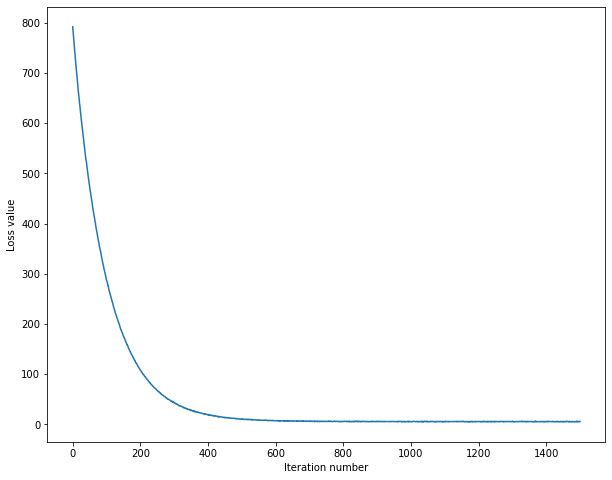

In [56]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [75]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371918
validation accuracy: 0.388000


In [83]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
path_set_rates = np.linspace(learning_rates[0],learning_rates[1],10)
path_set_reg = np.linspace(regularization_strengths[0],regularization_strengths[1],10)
for rate in path_set_rates:
    for reg_ in path_set_reg:
        svm = LinearSVM()
        svm.train(X_train, y_train, learning_rate=rate, reg=reg_,
                      num_iters=1500, verbose=False)
        trained_pred = svm.predict(X_train)
        train_ = np.sum(trained_pred == y_train)/X_train.shape[0]
        val_pred = svm.predict(X_val)
        val_ = np.sum(val_pred == y_val)/X_val.shape[0]
        results[(rate,reg_)] = (train_,val_)
        if val_>best_val:
            best_val = val_
            best_svm = svm
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1011.0
974.0
1005.0
1029.0
1007.0
973.0
977.0
922.0
984.0
978.0
1077.0
952.0
995.0
964.0
1001.0
1026.0
960.0
922.0
916.0
891.0
954.0
933.0
915.0
961.0
902.0
892.0
864.0
917.0
864.0
913.0
915.0
965.0
969.0
870.0
949.0
959.0
927.0
928.0
931.0
853.0
946.0
984.0
957.0
869.0
976.0
948.0
951.0
949.0
870.0
897.0
924.0
893.0
911.0
985.0
872.0
818.0
912.0
850.0
865.0
848.0
912.0
889.0
925.0
905.0
911.0
939.0
875.0
901.0
897.0
875.0
925.0
967.0
956.0
980.0
843.0
947.0
899.0
898.0
833.0
985.0
952.0
866.0
954.0
915.0
916.0
920.0
967.0
891.0
934.0
921.0
992.0
933.0
893.0
916.0
858.0
1003.0
919.0
976.0
932.0
925.0
936.0
981.0
985.0
932.0
941.0
934.0
984.0
914.0
885.0
958.0
981.0
958.0
855.0
892.0
898.0
945.0
927.0
881.0
984.0
936.0
954.0
959.0
917.0
891.0
950.0
942.0
889.0
1001.0
922.0
942.0
875.0
957.0
968.0
927.0
962.0
922.0
957.0
919.0
917.0
940.0
927.0
1002.0
964.0
990.0
913.0
942.0
963.0
899.0
1062.0
891.0
961.0
877.0
1004.0
1048.0
968.0
924.0
938.0
901.0
974.0
1005.0
912.0
960.0
997.0
882.0
10

1148.0
1205.0
1138.0
1143.0
1192.0
1112.0
1135.0
1148.0
1107.0
1156.0
1191.0
1135.0
1157.0
1063.0
1150.0
1146.0
1127.0
1154.0
1128.0
1134.0
1152.0
1070.0
1157.0
1169.0
1070.0
1094.0
1109.0
1166.0
1115.0
1106.0
1080.0
1089.0
1065.0
1135.0
1089.0
1104.0
1165.0
1066.0
1146.0
1038.0
1104.0
1132.0
1118.0
1036.0
1168.0
1070.0
1138.0
1141.0
1031.0
1102.0
1147.0
1192.0
1167.0
1122.0
1176.0
1110.0
1143.0
1191.0
1188.0
1148.0
1132.0
1116.0
1038.0
1145.0
1166.0
1081.0
1119.0
1144.0
1272.0
1171.0
1171.0
1130.0
1116.0
1106.0
1198.0
1125.0
1154.0
1150.0
1097.0
1175.0
1150.0
1180.0
1097.0
1140.0
1130.0
1065.0
1136.0
1098.0
1247.0
1186.0
1163.0
1125.0
1125.0
1096.0
1114.0
1153.0
1180.0
1111.0
1101.0
1077.0
1081.0
1095.0
1102.0
1131.0
1102.0
1135.0
1116.0
1152.0
1191.0
1136.0
1118.0
1120.0
1167.0
1124.0
1145.0
1158.0
1047.0
1071.0
1127.0
1207.0
1086.0
1158.0
1119.0
1129.0
1098.0
1132.0
1078.0
1154.0
1141.0
1127.0
1159.0
1100.0
1097.0
1109.0
1097.0
1165.0
1113.0
1136.0
1142.0
1132.0
1069.0
1089.0
1207.0

1149.0
1143.0
1035.0
1181.0
1111.0
1140.0
1190.0
1195.0
1136.0
1113.0
1162.0
1147.0
1168.0
1182.0
1146.0
1217.0
1128.0
1220.0
1091.0
1108.0
1140.0
1153.0
1123.0
1151.0
1149.0
1134.0
1153.0
1085.0
1168.0
1133.0
1119.0
1083.0
1159.0
1140.0
1198.0
1172.0
1168.0
1209.0
1116.0
1144.0
1143.0
1159.0
1153.0
1171.0
1158.0
1176.0
1102.0
1194.0
1194.0
1190.0
1139.0
1094.0
1172.0
1117.0
1134.0
1047.0
1094.0
1143.0
1110.0
1133.0
1223.0
1178.0
1061.0
1139.0
1167.0
1163.0
1127.0
1086.0
1074.0
1154.0
1134.0
1134.0
1181.0
1123.0
1067.0
1148.0
1113.0
1073.0
1091.0
1163.0
1141.0
1091.0
1112.0
1189.0
1164.0
1121.0
1193.0
1193.0
1185.0
1155.0
1132.0
1146.0
1177.0
1202.0
1182.0
1176.0
1156.0
1137.0
1205.0
1135.0
1185.0
1159.0
1168.0
1161.0
1067.0
1240.0
1165.0
1196.0
1181.0
1137.0
1113.0
1175.0
1075.0
1180.0
1164.0
1149.0
1123.0
1110.0
1205.0
1077.0
1164.0
1164.0
1141.0
1169.0
1174.0
1132.0
1087.0
1120.0
1106.0
1164.0
1143.0
1189.0
1117.0
1148.0
1112.0
1185.0
1043.0
1143.0
1194.0
1141.0
1095.0
1136.0
1030.0

1323.0
1145.0
1175.0
1185.0
1140.0
1193.0
1226.0
1150.0
1126.0
1183.0
1106.0
1173.0
1116.0
1159.0
1109.0
1187.0
1133.0
1115.0
1124.0
1163.0
1202.0
1170.0
1202.0
1181.0
1212.0
1179.0
1212.0
1105.0
1134.0
1179.0
1158.0
1151.0
1139.0
1107.0
1073.0
1190.0
1238.0
1093.0
1197.0
1135.0
1119.0
1149.0
1133.0
1198.0
1161.0
1148.0
1027.0
1165.0
1154.0
1165.0
1139.0
1201.0
1080.0
1151.0
1140.0
1144.0
1112.0
1169.0
1205.0
1198.0
1176.0
1191.0
1199.0
1197.0
1234.0
1174.0
1206.0
1167.0
1147.0
1149.0
1224.0
1194.0
1068.0
1177.0
1186.0
1125.0
1194.0
1166.0
1101.0
1083.0
1164.0
1132.0
1159.0
1149.0
1114.0
1172.0
1151.0
1147.0
1179.0
1145.0
1177.0
1137.0
1209.0
1138.0
1096.0
1149.0
1167.0
1212.0
1156.0
1144.0
1204.0
1148.0
1160.0
1128.0
1181.0
1219.0
1132.0
1186.0
1163.0
1145.0
1151.0
1183.0
1099.0
1216.0
1166.0
1153.0
1129.0
1113.0
1109.0
1113.0
1229.0
1228.0
1168.0
1078.0
1165.0
1150.0
1136.0
1156.0
1121.0
1148.0
1175.0
1145.0
1171.0
1150.0
1073.0
1137.0
1172.0
1164.0
1092.0
1158.0
1134.0
1136.0
1111.0

1106.0
1222.0
1101.0
1122.0
1113.0
1177.0
1160.0
1165.0
1181.0
1149.0
1167.0
1167.0
1175.0
1142.0
1124.0
1239.0
1109.0
1214.0
1213.0
1087.0
1232.0
1081.0
1150.0
1154.0
1108.0
1103.0
1145.0
1130.0
1171.0
1166.0
1158.0
1153.0
1162.0
1139.0
1155.0
1133.0
1101.0
1159.0
1138.0
1188.0
1157.0
1155.0
1147.0
1155.0
1166.0
1058.0
1075.0
1069.0
1149.0
1086.0
1086.0
1145.0
1114.0
1109.0
1147.0
1175.0
1110.0
1199.0
1152.0
1103.0
1160.0
1131.0
1162.0
1165.0
1113.0
1255.0
1035.0
1119.0
1124.0
1158.0
1155.0
1149.0
1142.0
1232.0
1207.0
1232.0
1169.0
1172.0
1120.0
1153.0
1150.0
1162.0
1138.0
1189.0
1191.0
1139.0
1135.0
1155.0
1166.0
1165.0
1158.0
1192.0
1087.0
1165.0
1116.0
1130.0
1150.0
1135.0
1219.0
1140.0
1150.0
1074.0
1159.0
1190.0
1106.0
1200.0
1099.0
1220.0
1171.0
1146.0
1182.0
1173.0
1119.0
1170.0
1177.0
1146.0
1187.0
1193.0
1174.0
1114.0
1189.0
1155.0
1100.0
1193.0
1173.0
1076.0
1163.0
1174.0
1149.0
1185.0
1138.0
1124.0
1251.0
1175.0
1182.0
1185.0
1164.0
1152.0
1161.0
1130.0
1144.0
1175.0
1173.0

1111.0
1165.0
1098.0
1167.0
1144.0
1287.0
1166.0
1096.0
1154.0
1183.0
1139.0
1104.0
1163.0
1087.0
1166.0
1250.0
1157.0
1159.0
1180.0
1219.0
1164.0
1189.0
1135.0
1133.0
1195.0
1083.0
1190.0
1213.0
1155.0
1226.0
1131.0
1133.0
1157.0
1130.0
1181.0
1235.0
1229.0
1221.0
1108.0
1156.0
1208.0
1097.0
1138.0
1214.0
1202.0
1160.0
1190.0
1120.0
1150.0
1146.0
1192.0
1144.0
1166.0
1162.0
1178.0
1153.0
1213.0
1107.0
1147.0
1163.0
1123.0
1067.0
1126.0
1175.0
1080.0
1131.0
1168.0
1142.0
1169.0
1175.0
1226.0
1165.0
1181.0
1182.0
1183.0
1212.0
1149.0
1165.0
1172.0
1165.0
1187.0
1184.0
1197.0
1202.0
1139.0
1152.0
1217.0
1251.0
1203.0
1227.0
1159.0
1250.0
1218.0
1190.0
1131.0
1160.0
1142.0
1210.0
1192.0
1185.0
1130.0
1199.0
1222.0
1195.0
1240.0
1127.0
1224.0
1156.0
1158.0
1159.0
1239.0
1164.0
1166.0
1156.0
1137.0
1143.0
1082.0
1134.0
1127.0
1175.0
1184.0
1089.0
1154.0
1161.0
1123.0
1180.0
1217.0
1184.0
1172.0
1127.0
1194.0
1178.0
1166.0
1106.0
1166.0
1169.0
1114.0
1160.0
1166.0
1132.0
1133.0
1170.0
1215.0

1188.0
1134.0
1081.0
1126.0
1106.0
1077.0
1130.0
1080.0
1055.0
1098.0
1091.0
1027.0
1058.0
1119.0
1017.0
995.0
987.0
1007.0
980.0
921.0
981.0
975.0
977.0
989.0
970.0
1014.0
1026.0
956.0
972.0
925.0
984.0
988.0
960.0
929.0
962.0
914.0
991.0
969.0
887.0
1015.0
979.0
972.0
942.0
946.0
1039.0
921.0
992.0
997.0
936.0
945.0
1017.0
994.0
972.0
907.0
876.0
955.0
945.0
953.0
863.0
982.0
889.0
950.0
924.0
1020.0
986.0
912.0
972.0
930.0
949.0
946.0
961.0
932.0
955.0
977.0
925.0
940.0
942.0
1096.0
896.0
973.0
940.0
921.0
999.0
949.0
948.0
951.0
1040.0
954.0
1045.0
967.0
1035.0
944.0
932.0
907.0
1022.0
1016.0
905.0
1022.0
960.0
941.0
991.0
1047.0
1003.0
953.0
945.0
992.0
866.0
934.0
1000.0
1030.0
995.0
1001.0
956.0
1011.0
964.0
1025.0
1029.0
956.0
960.0
959.0
977.0
1024.0
1024.0
1058.0
970.0
973.0
984.0
1013.0
1062.0
999.0
1098.0
1033.0
1051.0
1033.0
1081.0
1085.0
1023.0
1003.0
1120.0
1107.0
1082.0
1036.0
982.0
1059.0
1106.0
1018.0
1010.0
989.0
1008.0
1148.0
1061.0
1066.0
1049.0
983.0
1083.0
1046.0

1173.0
1218.0
1193.0
1220.0
1138.0
1173.0
1173.0
1238.0
1257.0
1180.0
1205.0
1162.0
1187.0
1134.0
1159.0
1148.0
1191.0
1191.0
1230.0
1132.0
1141.0
1253.0
1179.0
1226.0
1150.0
1242.0
1164.0
1162.0
1182.0
1263.0
1180.0
1204.0
1140.0
1220.0
1166.0
1162.0
1155.0
1209.0
1199.0
1259.0
1143.0
1151.0
1194.0
1187.0
1124.0
1177.0
1244.0
1169.0
1209.0
1208.0
1223.0
1270.0
1156.0
1222.0
1203.0
1135.0
1175.0
1140.0
1208.0
1169.0
1196.0
1141.0
1252.0
1158.0
1198.0
1138.0
1185.0
1154.0
1250.0
1209.0
1174.0
1225.0
1144.0
1211.0
1150.0
1166.0
1165.0
1189.0
1172.0
1145.0
1170.0
1105.0
1217.0
1117.0
1202.0
1161.0
1151.0
1193.0
1142.0
1162.0
1160.0
1154.0
1156.0
1200.0
1165.0
1222.0
1164.0
1168.0
1154.0
1171.0
1153.0
1144.0
1245.0
1188.0
1194.0
1178.0
1170.0
1205.0
1244.0
1195.0
1209.0
1140.0
1156.0
1178.0
1115.0
1223.0
1215.0
1201.0
1080.0
1105.0
1102.0
1184.0
1134.0
1136.0
1272.0
1223.0
1240.0
1154.0
1113.0
1192.0
1189.0
1158.0
1192.0
1123.0
1199.0
1180.0
1204.0
1211.0
1206.0
1181.0
1193.0
1161.0
1052.0

1201.0
1260.0
1144.0
1183.0
1188.0
1156.0
1143.0
1195.0
1170.0
1161.0
1207.0
1200.0
1193.0
1207.0
1239.0
1244.0
1197.0
1156.0
1189.0
1132.0
1235.0
1143.0
1188.0
1163.0
1095.0
1135.0
1173.0
1131.0
1154.0
1206.0
1160.0
1153.0
1166.0
1130.0
1142.0
1171.0
1215.0
1125.0
1202.0
1158.0
1202.0
1184.0
1175.0
1211.0
1210.0
1166.0
1194.0
1201.0
1122.0
1157.0
1139.0
1148.0
1165.0
1169.0
1173.0
1262.0
1156.0
1212.0
1108.0
1188.0
1198.0
1180.0
1199.0
1172.0
1133.0
1181.0
1212.0
1156.0
1138.0
1192.0
1159.0
1247.0
1200.0
1183.0
1250.0
1106.0
1143.0
1185.0
1140.0
1187.0
1173.0
1199.0
1237.0
1188.0
1169.0
1186.0
1201.0
1236.0
1203.0
1196.0
1214.0
1256.0
1197.0
1219.0
1186.0
1199.0
1174.0
1166.0
1200.0
1218.0
1175.0
1202.0
1199.0
1231.0
1197.0
1199.0
1146.0
1174.0
1236.0
1176.0
1132.0
1183.0
1189.0
1245.0
1148.0
1201.0
1164.0
1169.0
1163.0
1231.0
1205.0
1257.0
1150.0
1148.0
1205.0
1199.0
1188.0
1188.0
1175.0
1030.0
1160.0
1172.0
1220.0
1139.0
1215.0
1172.0
1123.0
1105.0
1171.0
1156.0
1155.0
1199.0
1284.0

1180.0
1119.0
1182.0
1206.0
1192.0
1220.0
1256.0
1257.0
1168.0
1155.0
1170.0
1188.0
1218.0
1156.0
1195.0
1162.0
1184.0
1214.0
1284.0
1200.0
1267.0
1259.0
1237.0
1166.0
1163.0
1224.0
1204.0
1184.0
1172.0
1280.0
1288.0
1253.0
1260.0
1175.0
1178.0
1269.0
1217.0
1236.0
1168.0
1099.0
1187.0
1279.0
1195.0
1217.0
1183.0
1182.0
1156.0
1195.0
1139.0
1169.0
1135.0
1126.0
1182.0
1224.0
1176.0
1237.0
1151.0
1193.0
1182.0
1141.0
1214.0
1214.0
1207.0
1131.0
1206.0
1192.0
1215.0
1138.0
1239.0
1146.0
1172.0
1194.0
1220.0
1251.0
1211.0
1174.0
1194.0
1184.0
1227.0
1246.0
1156.0
1168.0
1187.0
1226.0
1149.0
1205.0
1226.0
1209.0
1203.0
1190.0
1245.0
1303.0
1182.0
1228.0
1211.0
1194.0
1178.0
1182.0
1240.0
1219.0
1238.0
1280.0
1167.0
1170.0
1161.0
1253.0
1217.0
1156.0
1221.0
1189.0
1137.0
1221.0
1217.0
1230.0
1186.0
1149.0
1245.0
1190.0
1164.0
1175.0
1112.0
1217.0
1175.0
1191.0
1200.0
1120.0
1119.0
1143.0
1171.0
1230.0
1209.0
1228.0
1201.0
1250.0
1208.0
1192.0
1153.0
1291.0
1161.0
1170.0
1168.0
1174.0
1280.0

1181.0
1170.0
1196.0
1150.0
1150.0
1175.0
1183.0
1246.0
1208.0
1281.0
1201.0
1158.0
1198.0
1184.0
1197.0
1171.0
1199.0
1231.0
1233.0
1238.0
1226.0
1233.0
1256.0
1217.0
1227.0
1169.0
1258.0
1157.0
1237.0
1225.0
1221.0
1216.0
1212.0
1191.0
1268.0
1156.0
1204.0
1230.0
1236.0
1227.0
1166.0
1190.0
1230.0
1241.0
1131.0
1272.0
1216.0
1204.0
1239.0
1215.0
1186.0
1222.0
1186.0
1181.0
1254.0
1230.0
1179.0
1181.0
1207.0
1154.0
1167.0
1204.0
1232.0
1239.0
1178.0
1131.0
1225.0
1142.0
1186.0
1239.0
1113.0
1194.0
1170.0
1150.0
1205.0
1248.0
1175.0
1243.0
1138.0
1133.0
1148.0
1228.0
1189.0
1266.0
1193.0
1299.0
1239.0
1181.0
1219.0
1204.0
1114.0
1309.0
1165.0
1187.0
1231.0
1233.0
1232.0
1155.0
1190.0
1213.0
1192.0
1182.0
1208.0
1178.0
1148.0
1153.0
1101.0
1219.0
1240.0
1221.0
1151.0
1156.0
1284.0
1225.0
1200.0
1277.0
1219.0
1145.0
1201.0
1166.0
1292.0
1300.0
1231.0
1222.0
1195.0
1304.0
1227.0
1162.0
1191.0
1219.0
1132.0
1201.0
1231.0
1197.0
1181.0
1217.0
1188.0
1240.0
1182.0
1204.0
1158.0
1101.0
1157.0

1215.0
1134.0
1176.0
1180.0
1105.0
1212.0
1275.0
1224.0
1190.0
1203.0
1167.0
1160.0
1229.0
1200.0
1192.0
1063.0
1154.0
1234.0
1131.0
1172.0
1138.0
1196.0
1229.0
1178.0
1257.0
1280.0
1150.0
1189.0
1221.0
1168.0
1267.0
1186.0
1133.0
1157.0
1232.0
1189.0
1270.0
1239.0
1241.0
1245.0
1185.0
1149.0
1193.0
1218.0
1171.0
1169.0
1223.0
1208.0
1190.0
1173.0
1137.0
1244.0
1264.0
1192.0
1222.0
1256.0
1276.0
1220.0
1285.0
1261.0
1244.0
1228.0
1220.0
1211.0
1180.0
1191.0
1253.0
1212.0
1206.0
1126.0
1219.0
1149.0
1227.0
1188.0
1193.0
1136.0
1153.0
1175.0
1168.0
1234.0
1186.0
1250.0
1214.0
1229.0
1145.0
1185.0
1242.0
1203.0
1209.0
1195.0
1233.0
1219.0
1270.0
1240.0
1184.0
1163.0
1153.0
1179.0
1235.0
1231.0
1220.0
1229.0
1235.0
1258.0
1277.0
1179.0
1274.0
1229.0
1230.0
1265.0
1174.0
1211.0
1249.0
1227.0
1216.0
1220.0
1212.0
1211.0
1200.0
1237.0
1221.0
1188.0
1239.0
1187.0
1167.0
1204.0
1278.0
1296.0
1185.0
1214.0
1231.0
1198.0
1163.0
1213.0
1136.0
1232.0
1180.0
1203.0
1158.0
1242.0
1235.0
1246.0
1161.0

1160.0
1258.0
1229.0
1202.0
1231.0
1216.0
1259.0
1198.0
1280.0
1222.0
1314.0
1276.0
1204.0
1262.0
1235.0
1204.0
1253.0
1238.0
1259.0
1271.0
1244.0
1218.0
1149.0
1278.0
1182.0
1276.0
1175.0
1226.0
1229.0
1288.0
1218.0
1217.0
1161.0
1163.0
1232.0
1192.0
1244.0
1193.0
1148.0
1149.0
1212.0
1210.0
1204.0
1178.0
1235.0
1168.0
1187.0
1215.0
1190.0
1243.0
1226.0
1220.0
1227.0
1219.0
1210.0
1175.0
1169.0
1202.0
1202.0
1110.0
1230.0
1189.0
1272.0
1239.0
1211.0
1194.0
1155.0
1223.0
1208.0
1178.0
1211.0
989.0
771.0
744.0
812.0
800.0
785.0
750.0
855.0
921.0
737.0
786.0
796.0
805.0
855.0
781.0
770.0
861.0
735.0
732.0
842.0
794.0
808.0
793.0
847.0
784.0
889.0
688.0
707.0
878.0
718.0
762.0
814.0
817.0
878.0
775.0
785.0
740.0
846.0
807.0
747.0
757.0
860.0
789.0
833.0
901.0
693.0
832.0
843.0
817.0
824.0
772.0
805.0
867.0
813.0
813.0
955.0
722.0
737.0
768.0
773.0
921.0
871.0
822.0
795.0
746.0
775.0
840.0
774.0
714.0
865.0
760.0
708.0
763.0
787.0
746.0
828.0
748.0
830.0
868.0
788.0
828.0
833.0
780.0
838.0

859.0
756.0
728.0
911.0
830.0
792.0
824.0
887.0
780.0
770.0
824.0
769.0
831.0
830.0
818.0
834.0
784.0
835.0
792.0
807.0
816.0
894.0
840.0
796.0
817.0
840.0
808.0
876.0
870.0
782.0
856.0
922.0
841.0
798.0
825.0
866.0
786.0
697.0
886.0
757.0
795.0
914.0
791.0
758.0
632.0
895.0
876.0
671.0
710.0
811.0
815.0
817.0
824.0
797.0
793.0
784.0
802.0
823.0
768.0
800.0
870.0
779.0
777.0
755.0
803.0
788.0
828.0
894.0
848.0
758.0
778.0
868.0
797.0
834.0
706.0
800.0
744.0
787.0
881.0
764.0
867.0
789.0
789.0
873.0
811.0
788.0
895.0
875.0
834.0
760.0
801.0
852.0
853.0
817.0
855.0
791.0
808.0
797.0
837.0
741.0
737.0
856.0
810.0
857.0
839.0
787.0
807.0
791.0
735.0
856.0
845.0
809.0
908.0
797.0
786.0
770.0
789.0
748.0
825.0
764.0
819.0
872.0
705.0
698.0
863.0
738.0
843.0
696.0
808.0
953.0
785.0
812.0
821.0
771.0
715.0
743.0
766.0
853.0
767.0
782.0
881.0
781.0
759.0
832.0
799.0
875.0
754.0
775.0
856.0
832.0
816.0
780.0
882.0
773.0
833.0
840.0
694.0
901.0
727.0
823.0
865.0
847.0
783.0
868.0
735.0
827.0
830.

818.0
793.0
820.0
757.0
830.0
852.0
837.0
750.0
773.0
817.0
711.0
821.0
835.0
854.0
835.0
753.0
782.0
843.0
843.0
770.0
889.0
745.0
814.0
746.0
803.0
738.0
845.0
864.0
794.0
871.0
792.0
817.0
767.0
779.0
847.0
742.0
848.0
763.0
871.0
794.0
895.0
759.0
782.0
882.0
919.0
775.0
765.0
788.0
851.0
815.0
846.0
819.0
787.0
916.0
750.0
667.0
871.0
810.0
823.0
854.0
820.0
774.0
848.0
831.0
840.0
842.0
858.0
740.0
788.0
832.0
832.0
813.0
949.0
823.0
791.0
807.0
758.0
840.0
816.0
816.0
909.0
892.0
695.0
872.0
828.0
818.0
808.0
858.0
782.0
819.0
923.0
725.0
761.0
903.0
802.0
892.0
783.0
710.0
898.0
789.0
744.0
883.0
861.0
861.0
803.0
765.0
884.0
831.0
853.0
822.0
790.0
731.0
835.0
895.0
811.0
758.0
770.0
813.0
784.0
897.0
872.0
824.0
746.0
818.0
789.0
872.0
856.0
755.0
835.0
861.0
791.0
736.0
845.0
768.0
863.0
739.0
810.0
852.0
719.0
622.0
965.0
796.0
860.0
860.0
815.0
819.0
833.0
769.0
884.0
908.0
774.0
892.0
720.0
851.0
805.0
710.0
786.0
778.0
857.0
890.0
789.0
882.0
756.0
824.0
1006.0
679.0
755

850.0
752.0
880.0
828.0
782.0
801.0
767.0
846.0
766.0
808.0
851.0
818.0
814.0
850.0
674.0
769.0
914.0
816.0
870.0
805.0
855.0
726.0
865.0
834.0
818.0
817.0
794.0
807.0
836.0
814.0
859.0
853.0
759.0
807.0
809.0
837.0
768.0
910.0
823.0
748.0
848.0
779.0
715.0
876.0
760.0
901.0
918.0
838.0
819.0
792.0
735.0
890.0
766.0
824.0
893.0
870.0
803.0
834.0
814.0
825.0
766.0
855.0
795.0
802.0
784.0
841.0
803.0
689.0
859.0
819.0
892.0
790.0
829.0
753.0
856.0
971.0
764.0
722.0
752.0
839.0
885.0
756.0
884.0
829.0
710.0
856.0
783.0
741.0
866.0
774.0
862.0
842.0
775.0
852.0
780.0
899.0
821.0
732.0
932.0
778.0
915.0
784.0
947.0
836.0
765.0
832.0
931.0
733.0
779.0
987.0
701.0
775.0
759.0
906.0
884.0
832.0
850.0
868.0
801.0
884.0
827.0
908.0
772.0
798.0
855.0
874.0
848.0
866.0
817.0
752.0
814.0
844.0
781.0
839.0
849.0
896.0
802.0
786.0
842.0
705.0
822.0
820.0
791.0
849.0
875.0
857.0
780.0
803.0
974.0
805.0
750.0
965.0
892.0
739.0
910.0
828.0
720.0
823.0
776.0
840.0
843.0
856.0
759.0
807.0
784.0
901.0
824.

848.0
986.0
842.0
863.0
764.0
746.0
911.0
772.0
758.0
989.0
687.0
786.0
854.0
905.0
762.0
803.0
811.0
849.0
747.0
840.0
824.0
806.0
854.0
815.0
835.0
743.0
872.0
839.0
844.0
742.0
838.0
935.0
876.0
831.0
772.0
828.0
928.0
831.0
791.0
880.0
844.0
800.0
840.0
785.0
791.0
768.0
781.0
935.0
829.0
730.0
843.0
899.0
780.0
768.0
883.0
760.0
765.0
850.0
719.0
834.0
872.0
889.0
867.0
745.0
777.0
710.0
863.0
840.0
859.0
761.0
893.0
892.0
776.0
818.0
814.0
786.0
847.0
888.0
816.0
794.0
883.0
785.0
812.0
800.0
847.0
821.0
878.0
905.0
886.0
883.0
807.0
814.0
827.0
924.0
890.0
848.0
834.0
823.0
908.0
844.0
831.0
855.0
796.0
776.0
838.0
792.0
855.0
807.0
719.0
917.0
782.0
849.0
776.0
828.0
871.0
716.0
872.0
810.0
859.0
873.0
750.0
795.0
790.0
792.0
804.0
690.0
923.0
861.0
757.0
790.0
878.0
831.0
883.0
798.0
787.0
810.0
898.0
898.0
808.0
778.0
841.0
777.0
860.0
868.0
758.0
850.0
794.0
814.0
813.0
829.0
940.0
866.0
928.0
871.0
814.0
742.0
755.0
796.0
864.0
839.0
774.0
825.0
864.0
914.0
905.0
753.0
854.

855.0
918.0
744.0
824.0
824.0
851.0
806.0
958.0
830.0
738.0
793.0
870.0
810.0
827.0
856.0
867.0
848.0
839.0
830.0
832.0
892.0
787.0
933.0
820.0
824.0
937.0
764.0
783.0
831.0
927.0
932.0
843.0
786.0
852.0
789.0
707.0
880.0
823.0
842.0
869.0
772.0
833.0
854.0
869.0
855.0
768.0
798.0
907.0
798.0
946.0
769.0
845.0
842.0
845.0
803.0
873.0
845.0
819.0
846.0
882.0
901.0
786.0
921.0
802.0
743.0
854.0
834.0
923.0
770.0
887.0
802.0
858.0
765.0
786.0
870.0
815.0
951.0
783.0
736.0
842.0
794.0
840.0
875.0
748.0
858.0
833.0
788.0
839.0
799.0
916.0
787.0
779.0
836.0
843.0
779.0
873.0
803.0
908.0
770.0
899.0
810.0
872.0
901.0
803.0
838.0
803.0
778.0
817.0
863.0
816.0
846.0
791.0
832.0
862.0
696.0
763.0
841.0
791.0
811.0
701.0
773.0
888.0
853.0
812.0
874.0
785.0
876.0
896.0
884.0
867.0
807.0
803.0
838.0
855.0
857.0
928.0
731.0
782.0
918.0
855.0
899.0
822.0
890.0
946.0
832.0
898.0
812.0
872.0
841.0
870.0
776.0
802.0
773.0
826.0
773.0
819.0
794.0
893.0
806.0
816.0
888.0
742.0
820.0
952.0
838.0
879.0
790.

865.0
882.0
721.0
870.0
898.0
772.0
824.0
873.0
837.0
808.0
865.0
820.0
786.0
916.0
750.0
774.0
902.0
803.0
866.0
847.0
755.0
817.0
788.0
813.0
868.0
790.0
842.0
936.0
795.0
842.0
873.0
732.0
880.0
817.0
699.0
799.0
790.0
863.0
884.0
845.0
761.0
790.0
909.0
785.0
786.0
840.0
793.0
810.0
812.0
731.0
846.0
840.0
812.0
753.0
791.0
920.0
804.0
829.0
877.0
907.0
914.0
791.0
831.0
799.0
789.0
808.0
829.0
920.0
754.0
718.0
886.0
843.0
824.0
848.0
830.0
837.0
767.0
787.0
828.0
814.0
859.0
856.0
829.0
840.0
829.0
835.0
777.0
835.0
853.0
896.0
753.0
889.0
969.0
742.0
790.0
902.0
729.0
940.0
874.0
854.0
885.0
813.0
827.0
772.0
969.0
860.0
812.0
833.0
842.0
855.0
885.0
813.0
855.0
843.0
864.0
829.0
939.0
766.0
872.0
823.0
747.0
828.0
838.0
810.0
847.0
791.0
823.0
919.0
708.0
939.0
801.0
830.0
812.0
838.0
922.0
779.0
861.0
876.0
766.0
840.0
821.0
903.0
932.0
808.0
739.0
871.0
767.0
900.0
872.0
827.0
853.0
857.0
803.0
797.0
824.0
881.0
919.0
738.0
777.0
837.0
876.0
806.0
890.0
794.0
863.0
836.0
870.

779.0
869.0
770.0
886.0
900.0
856.0
826.0
842.0
894.0
777.0
939.0
897.0
776.0
893.0
884.0
751.0
937.0
807.0
908.0
832.0
872.0
797.0
862.0
896.0
816.0
954.0
786.0
800.0
855.0
906.0
917.0
922.0
847.0
781.0
899.0
925.0
816.0
795.0
878.0
779.0
811.0
861.0
860.0
820.0
933.0
810.0
813.0
828.0
768.0
792.0
885.0
814.0
850.0
896.0
817.0
843.0
797.0
778.0
883.0
941.0
809.0
855.0
834.0
863.0
806.0
808.0
879.0
855.0
947.0
894.0
853.0
771.0
874.0
904.0
774.0
764.0
862.0
854.0
787.0
842.0
898.0
833.0
837.0
883.0
778.0
804.0
848.0
812.0
814.0
869.0
864.0
723.0
821.0
993.0
748.0
810.0
906.0
817.0
916.0
784.0
933.0
785.0
829.0
761.0
773.0
971.0
705.0
951.0
875.0
809.0
841.0
808.0
885.0
778.0
852.0
800.0
822.0
836.0
930.0
806.0
823.0
814.0
826.0
861.0
872.0
817.0
804.0
902.0
858.0
875.0
882.0
832.0
801.0
830.0
952.0
850.0
910.0
877.0
881.0
794.0
910.0
875.0
860.0
816.0
840.0
923.0
889.0
868.0
855.0
696.0
789.0
916.0
900.0
824.0
762.0
932.0
833.0
937.0
802.0
843.0
855.0
825.0
861.0
844.0
855.0
909.0
852.

916.0
790.0
833.0
1011.0
830.0
703.0
842.0
873.0
833.0
857.0
812.0
795.0
942.0
977.0
791.0
842.0
863.0
785.0
885.0
822.0
819.0
901.0
809.0
904.0
771.0
949.0
825.0
824.0
795.0
859.0
839.0
799.0
930.0
919.0
968.0
854.0
822.0
833.0
914.0
880.0
879.0
861.0
845.0
784.0
880.0
889.0
899.0
756.0
816.0
867.0
924.0
808.0
892.0
899.0
825.0
896.0
892.0
800.0
868.0
747.0
947.0
857.0
880.0
912.0
863.0
809.0
836.0
960.0
806.0
840.0
839.0
737.0
792.0
728.0
842.0
825.0
850.0
889.0
861.0
863.0
888.0
841.0
843.0
896.0
761.0
901.0
829.0
837.0
798.0
841.0
878.0
841.0
869.0
780.0
915.0
785.0
789.0
800.0
802.0
864.0
856.0
875.0
806.0
805.0
841.0
871.0
959.0
830.0
952.0
842.0
750.0
867.0
869.0
819.0
844.0
844.0
872.0
838.0
892.0
871.0
857.0
832.0
907.0
899.0
843.0
817.0
826.0
767.0
843.0
789.0
887.0
871.0
918.0
854.0
826.0
844.0
878.0
899.0
920.0
790.0
954.0
837.0
833.0
832.0
854.0
805.0
885.0
797.0
828.0
994.0
774.0
860.0
943.0
827.0
811.0
854.0
790.0
864.0
813.0
899.0
868.0
926.0
752.0
754.0
798.0
871.0
809

863.0
841.0
859.0
823.0
814.0
830.0
907.0
881.0
971.0
835.0
860.0
863.0
906.0
805.0
799.0
898.0
817.0
811.0
896.0
833.0
880.0
857.0
790.0
907.0
800.0
890.0
933.0
794.0
948.0
909.0
817.0
876.0
866.0
850.0
875.0
840.0
871.0
944.0
800.0
854.0
873.0
893.0
796.0
814.0
815.0
874.0
786.0
921.0
804.0
873.0
915.0
851.0
839.0
869.0
859.0
775.0
859.0
807.0
804.0
906.0
849.0
881.0
774.0
899.0
898.0
849.0
845.0
827.0
869.0
847.0
874.0
857.0
847.0
952.0
826.0
867.0
846.0
850.0
875.0
923.0
872.0
866.0
732.0
930.0
762.0
881.0
915.0
850.0
865.0
884.0
800.0
873.0
783.0
828.0
931.0
912.0
848.0
822.0
768.0
863.0
878.0
818.0
775.0
889.0
867.0
995.0
839.0
877.0
862.0
830.0
799.0
827.0
855.0
730.0
812.0
903.0
874.0
807.0
813.0
821.0
866.0
817.0
757.0
881.0
811.0
902.0
762.0
887.0
840.0
877.0
834.0
933.0
827.0
900.0
921.0
790.0
907.0
760.0
829.0
858.0
893.0
881.0
838.0
773.0
955.0
903.0
886.0
950.0
838.0
810.0
872.0
889.0
949.0
736.0
846.0
909.0
776.0
866.0
866.0
727.0
863.0
961.0
792.0
848.0
855.0
927.0
944.

885.0
882.0
838.0
839.0
813.0
892.0
769.0
948.0
778.0
818.0
850.0
939.0
795.0
867.0
839.0
925.0
814.0
833.0
788.0
854.0
764.0
869.0
910.0
806.0
831.0
862.0
829.0
971.0
792.0
839.0
920.0
853.0
916.0
902.0
866.0
894.0
811.0
937.0
790.0
866.0
946.0
830.0
930.0
819.0
896.0
849.0
826.0
766.0
850.0
891.0
881.0
852.0
886.0
846.0
873.0
902.0
827.0
915.0
771.0
967.0
810.0
832.0
782.0
885.0
837.0
878.0
785.0
846.0
865.0
894.0
862.0
904.0
855.0
869.0
899.0
841.0
926.0
734.0
902.0
878.0
776.0
842.0
928.0
849.0
851.0
799.0
845.0
848.0
788.0
891.0
838.0
845.0
905.0
784.0
880.0
864.0
911.0
835.0
909.0
852.0
925.0
829.0
912.0
764.0
873.0
851.0
734.0
876.0
908.0
990.0
876.0
857.0
873.0
729.0
848.0
867.0
813.0
874.0
863.0
831.0
829.0
773.0
861.0
883.0
832.0
834.0
954.0
864.0
894.0
833.0
832.0
852.0
894.0
858.0
750.0
905.0
842.0
871.0
885.0
816.0
922.0
835.0
866.0
828.0
855.0
766.0
803.0
931.0
856.0
999.0
761.0
875.0
818.0
926.0
928.0
902.0
808.0
898.0
836.0
782.0
903.0
852.0
917.0
882.0
719.0
991.0
842.

836.0
792.0
789.0
803.0
758.0
705.0
811.0
788.0
827.0
764.0
658.0
766.0
852.0
784.0
794.0
786.0
846.0
869.0
802.0
789.0
810.0
800.0
932.0
793.0
832.0
716.0
813.0
800.0
747.0
783.0
867.0
727.0
879.0
799.0
738.0
805.0
705.0
768.0
746.0
754.0
894.0
807.0
800.0
891.0
727.0
821.0
827.0
831.0
865.0
818.0
777.0
738.0
775.0
777.0
793.0
910.0
745.0
836.0
786.0
765.0
750.0
837.0
833.0
886.0
781.0
877.0
776.0
786.0
753.0
806.0
736.0
805.0
898.0
756.0
838.0
827.0
778.0
950.0
760.0
836.0
839.0
857.0
790.0
718.0
741.0
826.0
835.0
844.0
804.0
852.0
756.0
792.0
741.0
800.0
754.0
799.0
823.0
842.0
810.0
816.0
866.0
844.0
847.0
835.0
809.0
816.0
810.0
809.0
753.0
787.0
772.0
771.0
848.0
774.0
865.0
797.0
868.0
711.0
851.0
746.0
799.0
835.0
805.0
753.0
850.0
781.0
799.0
705.0
784.0
986.0
771.0
694.0
785.0
715.0
828.0
705.0
897.0
771.0
749.0
812.0
829.0
831.0
755.0
766.0
794.0
748.0
841.0
850.0
709.0
805.0
738.0
806.0
771.0
694.0
843.0
843.0
783.0
841.0
813.0
737.0
826.0
656.0
839.0
791.0
898.0
727.0
749.

726.0
854.0
887.0
750.0
802.0
749.0
798.0
797.0
769.0
903.0
734.0
765.0
879.0
711.0
811.0
693.0
827.0
846.0
846.0
854.0
756.0
781.0
816.0
769.0
774.0
831.0
858.0
763.0
871.0
756.0
862.0
804.0
752.0
773.0
808.0
816.0
802.0
850.0
773.0
897.0
787.0
713.0
890.0
692.0
897.0
800.0
829.0
846.0
704.0
796.0
927.0
790.0
812.0
739.0
843.0
733.0
893.0
813.0
870.0
767.0
792.0
781.0
839.0
780.0
857.0
754.0
711.0
832.0
844.0
930.0
829.0
784.0
730.0
859.0
854.0
745.0
823.0
761.0
769.0
832.0
804.0
818.0
890.0
836.0
764.0
776.0
758.0
748.0
747.0
872.0
792.0
761.0
804.0
783.0
814.0
684.0
767.0
821.0
755.0
729.0
817.0
807.0
883.0
815.0
851.0
840.0
724.0
798.0
859.0
779.0
840.0
741.0
833.0
854.0
791.0
774.0
751.0
886.0
823.0
773.0
807.0
824.0
844.0
890.0
765.0
841.0
806.0
821.0
693.0
834.0
798.0
826.0
747.0
875.0
742.0
838.0
675.0
850.0
730.0
830.0
835.0
881.0
728.0
722.0
793.0
874.0
742.0
768.0
783.0
887.0
727.0
868.0
816.0
824.0
773.0
895.0
784.0
736.0
788.0
839.0
809.0
798.0
802.0
852.0
845.0
821.0
751.

876.0
829.0
821.0
826.0
845.0
728.0
849.0
763.0
847.0
726.0
783.0
792.0
908.0
781.0
751.0
810.0
793.0
872.0
756.0
867.0
777.0
830.0
869.0
851.0
787.0
894.0
763.0
809.0
829.0
786.0
801.0
747.0
867.0
804.0
744.0
866.0
814.0
778.0
875.0
738.0
710.0
896.0
849.0
918.0
806.0
907.0
804.0
883.0
827.0
862.0
898.0
854.0
825.0
775.0
816.0
881.0
796.0
771.0
873.0
847.0
746.0
823.0
815.0
887.0
893.0
810.0
859.0
784.0
835.0
889.0
811.0
794.0
805.0
828.0
721.0
840.0
774.0
773.0
844.0
855.0
703.0
806.0
801.0
780.0
769.0
849.0
844.0
886.0
783.0
835.0
826.0
842.0
913.0
780.0
817.0
801.0
913.0
855.0
716.0
855.0
827.0
828.0
822.0
827.0
801.0
855.0
831.0
824.0
850.0
814.0
821.0
806.0
791.0
780.0
787.0
763.0
767.0
817.0
786.0
750.0
833.0
750.0
770.0
807.0
918.0
771.0
883.0
803.0
847.0
772.0
858.0
808.0
834.0
758.0
889.0
833.0
803.0
740.0
954.0
853.0
758.0
843.0
877.0
746.0
811.0
810.0
807.0
882.0
800.0
766.0
930.0
767.0
901.0
800.0
808.0
866.0
805.0
827.0
923.0
800.0
855.0
791.0
835.0
792.0
889.0
748.0
849.

898.0
812.0
909.0
773.0
877.0
842.0
838.0
771.0
927.0
805.0
841.0
793.0
795.0
804.0
781.0
824.0
793.0
782.0
886.0
856.0
790.0
809.0
870.0
849.0
745.0
856.0
770.0
870.0
850.0
835.0
863.0
826.0
874.0
774.0
821.0
928.0
791.0
789.0
857.0
928.0
823.0
770.0
810.0
877.0
800.0
808.0
865.0
859.0
844.0
810.0
835.0
778.0
766.0
848.0
794.0
819.0
822.0
834.0
810.0
853.0
862.0
810.0
893.0
823.0
837.0
936.0
766.0
803.0
803.0
900.0
794.0
779.0
930.0
813.0
866.0
751.0
842.0
796.0
825.0
853.0
799.0
770.0
887.0
820.0
761.0
823.0
796.0
835.0
829.0
809.0
807.0
879.0
825.0
815.0
789.0
819.0
786.0
824.0
790.0
866.0
915.0
801.0
807.0
768.0
777.0
859.0
887.0
848.0
805.0
843.0
942.0
862.0
783.0
877.0
790.0
823.0
849.0
819.0
765.0
899.0
802.0
837.0
864.0
803.0
796.0
837.0
853.0
848.0
839.0
821.0
821.0
845.0
776.0
866.0
729.0
849.0
844.0
903.0
871.0
802.0
798.0
865.0
788.0
808.0
788.0
890.0
840.0
814.0
866.0
763.0
811.0
821.0
794.0
832.0
726.0
890.0
840.0
757.0
855.0
828.0
822.0
753.0
805.0
810.0
797.0
853.0
928.

770.0
765.0
824.0
726.0
828.0
821.0
827.0
798.0
856.0
794.0
854.0
830.0
855.0
804.0
905.0
893.0
760.0
801.0
824.0
825.0
865.0
891.0
832.0
884.0
831.0
857.0
806.0
873.0
898.0
678.0
873.0
823.0
808.0
806.0
753.0
791.0
807.0
863.0
904.0
721.0
843.0
921.0
820.0
872.0
803.0
841.0
784.0
893.0
833.0
845.0
1148.0
659.0
934.0
767.0
831.0
878.0
869.0
744.0
891.0
747.0
924.0
812.0
988.0
703.0
840.0
779.0
951.0
775.0
872.0
791.0
966.0
785.0
930.0
884.0
896.0
814.0
876.0
800.0
902.0
700.0
877.0
883.0
845.0
772.0
908.0
797.0
917.0
796.0
925.0
797.0
799.0
779.0
910.0
756.0
805.0
807.0
856.0
835.0
833.0
676.0
803.0
753.0
843.0
800.0
921.0
843.0
851.0
870.0
747.0
766.0
808.0
813.0
796.0
854.0
864.0
807.0
924.0
804.0
728.0
847.0
874.0
856.0
734.0
842.0
874.0
750.0
806.0
869.0
724.0
802.0
839.0
788.0
922.0
826.0
749.0
922.0
779.0
828.0
844.0
817.0
861.0
796.0
840.0
816.0
823.0
812.0
830.0
847.0
889.0
780.0
893.0
804.0
858.0
823.0
810.0
839.0
824.0
767.0
877.0
788.0
881.0
770.0
898.0
857.0
857.0
941.0
790

851.0
821.0
804.0
818.0
806.0
807.0
849.0
865.0
770.0
876.0
838.0
876.0
861.0
803.0
841.0
813.0
964.0
780.0
795.0
877.0
757.0
809.0
848.0
891.0
761.0
858.0
837.0
794.0
952.0
827.0
784.0
979.0
804.0
875.0
853.0
787.0
848.0
816.0
809.0
773.0
841.0
860.0
819.0
792.0
816.0
943.0
844.0
864.0
756.0
852.0
782.0
868.0
765.0
1003.0
881.0
773.0
741.0
797.0
850.0
741.0
934.0
909.0
853.0
847.0
858.0
831.0
791.0
804.0
811.0
825.0
760.0
914.0
836.0
845.0
727.0
847.0
853.0
736.0
762.0
836.0
768.0
862.0
826.0
909.0
812.0
835.0
793.0
793.0
902.0
834.0
871.0
903.0
787.0
850.0
739.0
831.0
826.0
799.0
842.0
820.0
934.0
817.0
836.0
761.0
860.0
835.0
870.0
791.0
877.0
736.0
937.0
896.0
867.0
757.0
878.0
798.0
809.0
782.0
830.0
906.0
822.0
960.0
715.0
826.0
810.0
836.0
760.0
818.0
900.0
834.0
816.0
831.0
855.0
754.0
883.0
837.0
842.0
840.0
837.0
781.0
965.0
898.0
935.0
832.0
785.0
1088.0
730.0
965.0
810.0
849.0
789.0
807.0
887.0
768.0
821.0
885.0
833.0
885.0
873.0
800.0
844.0
866.0
877.0
895.0
841.0
871.0
85

824.0
847.0
790.0
821.0
801.0
790.0
877.0
847.0
778.0
897.0
790.0
863.0
886.0
797.0
833.0
825.0
824.0
856.0
855.0
954.0
807.0
916.0
841.0
792.0
850.0
883.0
767.0
912.0
806.0
811.0
819.0
794.0
863.0
780.0
863.0
867.0
907.0
827.0
825.0
851.0
790.0
868.0
782.0
816.0
864.0
857.0
863.0
884.0
871.0
734.0
847.0
851.0
776.0
946.0
840.0
878.0
754.0
894.0
896.0
923.0
776.0
855.0
876.0
904.0
758.0
935.0
884.0
880.0
763.0
939.0
756.0
872.0
781.0
903.0
852.0
786.0
912.0
839.0
858.0
807.0
838.0
871.0
913.0
772.0
815.0
858.0
807.0
859.0
837.0
792.0
883.0
871.0
857.0
895.0
849.0
897.0
832.0
817.0
860.0
887.0
883.0
811.0
855.0
880.0
840.0
884.0
913.0
915.0
797.0
767.0
878.0
840.0
786.0
921.0
828.0
843.0
844.0
805.0
845.0
819.0
784.0
839.0
778.0
884.0
815.0
867.0
843.0
894.0
858.0
827.0
890.0
889.0
755.0
773.0
825.0
727.0
831.0
756.0
959.0
786.0
911.0
771.0
837.0
831.0
854.0
795.0
876.0
849.0
948.0
792.0
834.0
890.0
867.0
827.0
774.0
879.0
879.0
871.0
857.0
845.0
740.0
878.0
913.0
783.0
853.0
843.0
795.

885.0
905.0
782.0
871.0
812.0
856.0
803.0
926.0
837.0
796.0
903.0
798.0
842.0
913.0
786.0
883.0
790.0
873.0
829.0
930.0
882.0
892.0
767.0
891.0
802.0
780.0
835.0
871.0
845.0
788.0
877.0
850.0
841.0
906.0
783.0
858.0
810.0
810.0
887.0
825.0
779.0
858.0
939.0
883.0
855.0
829.0
798.0
857.0
903.0
805.0
879.0
848.0
855.0
894.0
823.0
889.0
812.0
809.0
886.0
757.0
821.0
777.0
824.0
858.0
853.0
898.0
841.0
892.0
902.0
841.0
886.0
854.0
850.0
872.0
790.0
880.0
893.0
913.0
837.0
917.0
803.0
838.0
886.0
811.0
896.0
887.0
872.0
808.0
817.0
816.0
813.0
846.0
760.0
884.0
763.0
906.0
746.0
918.0
794.0
900.0
851.0
824.0
819.0
866.0
797.0
895.0
780.0
960.0
868.0
931.0
824.0
907.0
848.0
872.0
811.0
860.0
885.0
931.0
812.0
837.0
837.0
814.0
859.0
812.0
820.0
847.0
834.0
876.0
862.0
804.0
878.0
890.0
774.0
827.0
857.0
775.0
824.0
908.0
920.0
753.0
867.0
845.0
806.0
869.0
867.0
858.0
935.0
824.0
887.0
837.0
925.0
741.0
811.0
860.0
921.0
875.0
846.0
813.0
904.0
887.0
888.0
825.0
854.0
844.0
865.0
836.0
813.

854.0
893.0
897.0
847.0
779.0
975.0
719.0
1016.0
848.0
934.0
740.0
939.0
815.0
877.0
738.0
833.0
815.0
962.0
765.0
880.0
878.0
880.0
735.0
948.0
741.0
889.0
792.0
880.0
818.0
945.0
800.0
987.0
768.0
909.0
745.0
898.0
721.0
956.0
737.0
1002.0
779.0
961.0
729.0
1025.0
686.0
978.0
796.0
967.0
823.0
939.0
718.0
1009.0
759.0
847.0
810.0
921.0
860.0
825.0
836.0
742.0
920.0
807.0
888.0
868.0
815.0
853.0
891.0
842.0
848.0
892.0
755.0
771.0
896.0
896.0
932.0
822.0
852.0
981.0
818.0
856.0
833.0
900.0
837.0
869.0
812.0
855.0
803.0
860.0
808.0
914.0
877.0
755.0
883.0
898.0
811.0
797.0
847.0
968.0
939.0
794.0
962.0
733.0
799.0
900.0
858.0
811.0
895.0
838.0
842.0
872.0
840.0
880.0
820.0
880.0
801.0
869.0
845.0
886.0
882.0
985.0
781.0
875.0
857.0
902.0
866.0
851.0
740.0
844.0
842.0
890.0
762.0
803.0
837.0
893.0
815.0
877.0
826.0
915.0
819.0
1000.0
793.0
912.0
744.0
896.0
724.0
914.0
794.0
867.0
821.0
942.0
816.0
861.0
787.0
930.0
807.0
848.0
777.0
844.0
892.0
892.0
812.0
957.0
869.0
901.0
744.0
942.0

843.0
737.0
945.0
798.0
951.0
813.0
905.0
721.0
884.0
856.0
883.0
856.0
842.0
845.0
893.0
796.0
918.0
793.0
836.0
822.0
868.0
926.0
795.0
903.0
834.0
885.0
886.0
875.0
845.0
800.0
823.0
887.0
842.0
851.0
793.0
1016.0
789.0
904.0
819.0
874.0
815.0
853.0
882.0
907.0
845.0
901.0
854.0
877.0
888.0
866.0
855.0
869.0
876.0
876.0
886.0
930.0
811.0
900.0
840.0
867.0
778.0
937.0
793.0
867.0
839.0
911.0
761.0
837.0
782.0
881.0
874.0
998.0
839.0
814.0
753.0
815.0
844.0
886.0
850.0
882.0
782.0
892.0
841.0
932.0
797.0
902.0
814.0
894.0
773.0
906.0
958.0
866.0
860.0
851.0
866.0
926.0
832.0
867.0
865.0
958.0
787.0
911.0
770.0
872.0
807.0
868.0
845.0
936.0
786.0
934.0
834.0
949.0
740.0
863.0
801.0
972.0
764.0
925.0
809.0
939.0
725.0
811.0
804.0
930.0
850.0
921.0
801.0
834.0
869.0
806.0
913.0
872.0
849.0
884.0
906.0
796.0
886.0
824.0
877.0
729.0
879.0
807.0
913.0
905.0
739.0
969.0
822.0
876.0
754.0
976.0
841.0
826.0
816.0
920.0
792.0
1019.0
741.0
926.0
795.0
949.0
717.0
878.0
813.0
830.0
845.0
888.0
77

756.0
985.0
803.0
990.0
774.0
901.0
785.0
893.0
826.0
967.0
791.0
959.0
788.0
940.0
843.0
889.0
823.0
1019.0
851.0
890.0
929.0
875.0
873.0
908.0
786.0
955.0
854.0
925.0
777.0
945.0
777.0
974.0
885.0
883.0
885.0
944.0
805.0
824.0
851.0
895.0
860.0
921.0
937.0
872.0
833.0
789.0
917.0
860.0
812.0
879.0
856.0
821.0
893.0
868.0
911.0
871.0
805.0
839.0
882.0
837.0
826.0
754.0
904.0
863.0
941.0
859.0
920.0
883.0
905.0
851.0
862.0
819.0
843.0
847.0
821.0
763.0
873.0
847.0
821.0
846.0
899.0
861.0
888.0
814.0
858.0
831.0
872.0
823.0
803.0
852.0
847.0
904.0
864.0
893.0
903.0
871.0
909.0
824.0
799.0
881.0
910.0
789.0
849.0
821.0
847.0
912.0
871.0
713.0
902.0
865.0
901.0
872.0
852.0
787.0
780.0
805.0
941.0
840.0
908.0
871.0
899.0
807.0
900.0
904.0
903.0
841.0
858.0
829.0
975.0
804.0
869.0
788.0
937.0
896.0
867.0
834.0
783.0
917.0
927.0
923.0
860.0
818.0
842.0
832.0
868.0
841.0
922.0
891.0
869.0
820.0
897.0
863.0
798.0
856.0
798.0
845.0
759.0
865.0
805.0
789.0
866.0
865.0
902.0
856.0
836.0
818.0
802

753.0
861.0
807.0
846.0
790.0
868.0
717.0
756.0
789.0
909.0
761.0
1010.0
789.0
854.0
759.0
939.0
764.0
901.0
838.0
888.0
691.0
833.0
728.0
813.0
778.0
871.0
854.0
868.0
805.0
837.0
737.0
832.0
763.0
844.0
777.0
800.0
775.0
937.0
745.0
907.0
746.0
873.0
852.0
820.0
810.0
901.0
759.0
760.0
834.0
820.0
771.0
935.0
813.0
783.0
832.0
819.0
649.0
850.0
742.0
767.0
896.0
747.0
791.0
803.0
766.0
891.0
877.0
776.0
760.0
802.0
833.0
820.0
890.0
835.0
801.0
876.0
722.0
848.0
763.0
926.0
745.0
819.0
792.0
832.0
763.0
798.0
862.0
812.0
855.0
729.0
915.0
762.0
759.0
784.0
874.0
734.0
858.0
737.0
834.0
761.0
825.0
751.0
781.0
835.0
724.0
889.0
783.0
866.0
842.0
805.0
842.0
825.0
821.0
749.0
850.0
771.0
835.0
865.0
871.0
787.0
868.0
766.0
769.0
730.0
908.0
784.0
741.0
853.0
899.0
760.0
780.0
811.0
774.0
809.0
866.0
825.0
798.0
879.0
763.0
790.0
818.0
855.0
826.0
802.0
829.0
923.0
749.0
827.0
811.0
927.0
752.0
947.0
805.0
785.0
814.0
822.0
873.0
816.0
776.0
888.0
751.0
847.0
795.0
873.0
814.0
913.0
784

901.0
857.0
822.0
842.0
805.0
799.0
810.0
900.0
740.0
880.0
763.0
768.0
805.0
767.0
827.0
812.0
798.0
833.0
855.0
829.0
836.0
792.0
818.0
861.0
802.0
799.0
835.0
843.0
794.0
809.0
915.0
753.0
837.0
752.0
885.0
859.0
785.0
836.0
816.0
859.0
838.0
863.0
869.0
798.0
746.0
847.0
852.0
824.0
833.0
758.0
846.0
773.0
845.0
805.0
822.0
799.0
936.0
763.0
844.0
826.0
829.0
858.0
900.0
815.0
855.0
756.0
789.0
734.0
924.0
749.0
878.0
793.0
864.0
862.0
944.0
798.0
873.0
820.0
835.0
746.0
800.0
825.0
923.0
790.0
758.0
811.0
690.0
783.0
831.0
760.0
837.0
868.0
849.0
772.0
825.0
834.0
818.0
806.0
833.0
917.0
828.0
821.0
828.0
881.0
730.0
880.0
875.0
842.0
855.0
835.0
808.0
928.0
798.0
819.0
825.0
930.0
850.0
842.0
835.0
849.0
812.0
860.0
919.0
915.0
750.0
791.0
891.0
820.0
781.0
773.0
897.0
851.0
929.0
825.0
783.0
766.0
833.0
844.0
858.0
817.0
849.0
823.0
909.0
802.0
893.0
790.0
869.0
711.0
809.0
797.0
849.0
765.0
906.0
762.0
898.0
746.0
889.0
815.0
897.0
797.0
881.0
738.0
829.0
823.0
851.0
748.0
923.

853.0
932.0
836.0
855.0
866.0
823.0
869.0
926.0
828.0
926.0
919.0
876.0
889.0
831.0
805.0
823.0
897.0
925.0
898.0
830.0
821.0
791.0
895.0
873.0
781.0
871.0
851.0
862.0
860.0
929.0
825.0
864.0
796.0
865.0
854.0
905.0
853.0
765.0
871.0
834.0
879.0
864.0
791.0
878.0
796.0
865.0
780.0
810.0
879.0
878.0
860.0
846.0
793.0
856.0
788.0
897.0
808.0
804.0
703.0
933.0
800.0
904.0
780.0
884.0
845.0
907.0
747.0
934.0
710.0
797.0
828.0
893.0
857.0
862.0
796.0
832.0
798.0
841.0
845.0
851.0
749.0
894.0
788.0
833.0
824.0
859.0
823.0
934.0
818.0
784.0
816.0
888.0
823.0
797.0
854.0
757.0
772.0
815.0
836.0
776.0
912.0
801.0
841.0
903.0
862.0
947.0
738.0
898.0
876.0
951.0
793.0
881.0
801.0
848.0
755.0
874.0
847.0
764.0
916.0
859.0
934.0
785.0
896.0
897.0
830.0
883.0
821.0
921.0
736.0
833.0
756.0
809.0
825.0
846.0
839.0
866.0
792.0
813.0
805.0
737.0
864.0
794.0
831.0
851.0
825.0
835.0
853.0
877.0
802.0
831.0
912.0
837.0
850.0
850.0
827.0
857.0
857.0
851.0
862.0
801.0
844.0
772.0
863.0
919.0
825.0
838.0
849.

835.0
819.0
906.0
750.0
910.0
741.0
913.0
892.0
892.0
824.0
874.0
872.0
920.0
743.0
830.0
806.0
860.0
877.0
951.0
793.0
789.0
780.0
853.0
843.0
817.0
885.0
788.0
866.0
827.0
856.0
841.0
956.0
793.0
890.0
762.0
896.0
797.0
909.0
793.0
839.0
817.0
892.0
803.0
880.0
806.0
930.0
864.0
867.0
857.0
893.0
882.0
848.0
792.0
842.0
792.0
830.0
790.0
845.0
844.0
837.0
813.0
814.0
876.0
847.0
906.0
883.0
791.0
868.0
913.0
763.0
936.0
833.0
844.0
807.0
859.0
853.0
798.0
879.0
916.0
867.0
778.0
927.0
727.0
952.0
817.0
882.0
766.0
822.0
822.0
906.0
816.0
823.0
858.0
908.0
852.0
870.0
795.0
848.0
825.0
891.0
891.0
911.0
751.0
915.0
841.0
946.0
859.0
866.0
856.0
820.0
838.0
801.0
845.0
812.0
799.0
934.0
852.0
777.0
816.0
873.0
843.0
866.0
866.0
816.0
876.0
823.0
911.0
790.0
910.0
874.0
805.0
817.0
884.0
711.0
955.0
829.0
839.0
799.0
923.0
862.0
889.0
852.0
855.0
809.0
885.0
764.0
887.0
829.0
971.0
805.0
869.0
808.0
878.0
844.0
847.0
833.0
880.0
869.0
752.0
829.0
880.0
824.0
891.0
829.0
878.0
862.0
873.

886.0
814.0
895.0
835.0
857.0
816.0
868.0
958.0
887.0
783.0
804.0
857.0
913.0
898.0
849.0
830.0
849.0
923.0
839.0
887.0
866.0
890.0
785.0
814.0
843.0
934.0
804.0
838.0
890.0
784.0
865.0
861.0
887.0
931.0
852.0
868.0
846.0
820.0
740.0
930.0
890.0
961.0
910.0
844.0
766.0
1023.0
852.0
906.0
899.0
918.0
772.0
926.0
819.0
814.0
822.0
819.0
828.0
929.0
772.0
899.0
826.0
819.0
868.0
788.0
891.0
828.0
918.0
783.0
949.0
858.0
838.0
874.0
860.0
766.0
879.0
806.0
938.0
811.0
908.0
818.0
885.0
878.0
928.0
966.0
800.0
907.0
888.0
837.0
846.0
905.0
950.0
859.0
851.0
920.0
934.0
836.0
857.0
944.0
877.0
902.0
849.0
916.0
777.0
932.0
787.0
934.0
772.0
950.0
746.0
826.0
750.0
911.0
817.0
936.0
830.0
899.0
765.0
857.0
903.0
817.0
891.0
874.0
866.0
870.0
801.0
872.0
797.0
908.0
892.0
828.0
898.0
954.0
861.0
864.0
864.0
809.0
828.0
839.0
887.0
907.0
934.0
859.0
791.0
858.0
798.0
900.0
810.0
922.0
892.0
891.0
793.0
790.0
870.0
916.0
806.0
933.0
757.0
843.0
852.0
910.0
842.0
832.0
800.0
839.0
898.0
922.0
829

808.0
937.0
822.0
877.0
786.0
888.0
751.0
881.0
886.0
848.0
850.0
950.0
844.0
951.0
834.0
904.0
862.0
885.0
854.0
972.0
827.0
908.0
927.0
861.0
857.0
879.0
899.0
863.0
885.0
882.0
876.0
852.0
854.0
935.0
813.0
911.0
899.0
939.0
777.0
896.0
855.0
911.0
876.0
871.0
802.0
858.0
893.0
882.0
835.0
854.0
812.0
802.0
814.0
842.0
898.0
873.0
910.0
897.0
929.0
821.0
904.0
828.0
842.0
816.0
885.0
812.0
833.0
858.0
924.0
850.0
907.0
869.0
906.0
865.0
892.0
839.0
911.0
897.0
911.0
896.0
766.0
834.0
864.0
943.0
807.0
831.0
870.0
879.0
775.0
890.0
913.0
901.0
749.0
880.0
778.0
974.0
823.0
931.0
819.0
892.0
854.0
836.0
805.0
806.0
766.0
897.0
778.0
921.0
720.0
919.0
820.0
883.0
794.0
916.0
826.0
970.0
848.0
926.0
852.0
954.0
799.0
1029.0
786.0
925.0
768.0
954.0
752.0
989.0
819.0
915.0
788.0
851.0
830.0
907.0
833.0
860.0
800.0
968.0
929.0
844.0
870.0
857.0
808.0
967.0
779.0
905.0
821.0
890.0
793.0
938.0
820.0
871.0
844.0
914.0
876.0
916.0
774.0
946.0
830.0
879.0
844.0
836.0
903.0
979.0
925.0
830.0
820

884.0
725.0
957.0
838.0
897.0
799.0
957.0
821.0
989.0
831.0
1016.0
803.0
1024.0
749.0
1017.0
803.0
953.0
849.0
907.0
737.0
1043.0
685.0
1020.0
782.0
963.0
755.0
1019.0
801.0
1005.0
729.0
1007.0
767.0
1059.0
763.0
984.0
803.0
976.0
735.0
952.0
765.0
995.0
770.0
990.0
797.0
882.0
714.0
958.0
854.0
889.0
834.0
883.0
873.0
916.0
767.0
898.0
757.0
840.0
805.0
951.0
801.0
880.0
754.0
844.0
802.0
930.0
888.0
867.0
888.0
957.0
865.0
883.0
859.0
847.0
865.0
881.0
908.0
990.0
936.0
882.0
861.0
856.0
852.0
900.0
838.0
864.0
918.0
883.0
910.0
813.0
951.0
808.0
887.0
859.0
875.0
848.0
859.0
830.0
876.0
895.0
950.0
935.0
824.0
925.0
828.0
924.0
878.0
846.0
846.0
870.0
940.0
891.0
897.0
849.0
929.0
855.0
891.0
868.0
898.0
1007.0
842.0
891.0
785.0
863.0
932.0
855.0
906.0
875.0
908.0
971.0
876.0
929.0
866.0
796.0
961.0
833.0
845.0
904.0
873.0
915.0
874.0
897.0
898.0
906.0
880.0
891.0
831.0
881.0
774.0
898.0
877.0
875.0
905.0
786.0
870.0
934.0
828.0
851.0
816.0
931.0
924.0
854.0
865.0
863.0
882.0
859.0


973.0
877.0
938.0
889.0
900.0
784.0
850.0
809.0
963.0
931.0
849.0
888.0
873.0
876.0
884.0
915.0
846.0
879.0
907.0
912.0
835.0
943.0
881.0
874.0
918.0
917.0
863.0
959.0
908.0
896.0
894.0
770.0
824.0
852.0
900.0
904.0
823.0
908.0
915.0
884.0
879.0
895.0
850.0
910.0
898.0
997.0
802.0
847.0
856.0
904.0
823.0
905.0
845.0
952.0
876.0
965.0
760.0
1011.0
891.0
951.0
849.0
940.0
866.0
975.0
814.0
942.0
803.0
982.0
827.0
953.0
791.0
999.0
889.0
957.0
805.0
945.0
818.0
965.0
837.0
800.0
774.0
923.0
751.0
1019.0
779.0
923.0
734.0
1082.0
793.0
1005.0
819.0
991.0
828.0
951.0
858.0
975.0
779.0
895.0
768.0
957.0
806.0
1059.0
747.0
970.0
781.0
956.0
869.0
959.0
783.0
972.0
781.0
1034.0
766.0
1004.0
744.0
903.0
797.0
942.0
811.0
991.0
775.0
937.0
828.0
907.0
791.0
892.0
866.0
1021.0
836.0
971.0
830.0
1017.0
832.0
894.0
806.0
955.0
847.0
926.0
882.0
1039.0
790.0
1050.0
891.0
947.0
908.0
997.0
848.0
975.0
872.0
945.0
766.0
880.0
767.0
973.0
878.0
941.0
833.0
1043.0
814.0
986.0
811.0
914.0
848.0
928.0
837.

786.0
1142.0
719.0
1101.0
782.0
1062.0
711.0
1036.0
711.0
1023.0
755.0
862.0
745.0
1096.0
794.0
939.0
842.0
1024.0
770.0
1029.0
743.0
1105.0
686.0
1092.0
747.0
1095.0
666.0
1053.0
755.0
1121.0
676.0
1022.0
777.0
1013.0
770.0
1019.0
724.0
989.0
823.0
1012.0
806.0
1015.0
759.0
956.0
788.0
1009.0
737.0
1049.0
736.0
1077.0
856.0
938.0
780.0
948.0
714.0
992.0
785.0
939.0
742.0
1033.0
702.0
1005.0
869.0
980.0
689.0
1133.0
758.0
1125.0
705.0
996.0
674.0
1062.0
700.0
952.0
650.0
994.0
756.0
960.0
758.0
1031.0
738.0
1084.0
758.0
1008.0
816.0
1025.0
787.0
948.0
795.0
1047.0
837.0
1058.0
710.0
991.0
778.0
1037.0
746.0
1022.0
790.0
1041.0
791.0
1008.0
735.0
1034.0
731.0
1039.0
752.0
1103.0
776.0
1133.0
654.0
1088.0
773.0
1095.0
795.0
1026.0
728.0
1057.0
756.0
1038.0
762.0
1065.0
757.0
1077.0
742.0
1047.0
776.0
1050.0
761.0
1009.0
739.0
979.0
727.0
1008.0
702.0
1050.0
718.0
1023.0
788.0
1057.0
756.0
1056.0
753.0
1047.0
773.0
995.0
808.0
1019.0
798.0
945.0
766.0
965.0
786.0
1034.0
768.0
1017.0
803.0

1071.0
784.0
1110.0
773.0
1059.0
739.0
1058.0
754.0
1096.0
746.0
1050.0
697.0
1072.0
749.0
1106.0
708.0
1029.0
710.0
1025.0
619.0
1015.0
761.0
1081.0
775.0
1054.0
752.0
1055.0
697.0
1065.0
725.0
1002.0
769.0
1076.0
772.0
1078.0
768.0
1025.0
694.0
1092.0
665.0
1042.0
708.0
1087.0
690.0
1034.0
691.0
1062.0
724.0
1022.0
769.0
1063.0
724.0
1076.0
777.0
1098.0
776.0
1053.0
695.0
1026.0
668.0
1127.0
694.0
1055.0
750.0
1086.0
696.0
1005.0
742.0
1121.0
738.0
1075.0
693.0
1085.0
706.0
1033.0
710.0
1096.0
680.0
1054.0
723.0
1018.0
716.0
1017.0
727.0
1089.0
759.0
1075.0
632.0
1104.0
709.0
1082.0
755.0
1067.0
693.0
986.0
735.0
1044.0
715.0
1065.0
814.0
1004.0
676.0
1048.0
624.0
1134.0
734.0
1088.0
699.0
1094.0
723.0
1041.0
762.0
1022.0
719.0
1017.0
685.0
1033.0
752.0
1021.0
695.0
1043.0
670.0
1119.0
755.0
1143.0
683.0
1089.0
650.0
1102.0
684.0
1037.0
668.0
1093.0
734.0
1115.0
659.0
1088.0
726.0
1031.0
729.0
1066.0
717.0
1068.0
635.0
1025.0
773.0
1085.0
720.0
1105.0
738.0
1137.0
669.0
1114.0
702.0


1002.0
810.0
980.0
819.0
897.0
820.0
1008.0
852.0
1023.0
819.0
991.0
848.0
972.0
848.0
943.0
791.0
1024.0
783.0
1052.0
767.0
1021.0
828.0
921.0
776.0
956.0
776.0
1064.0
808.0
1013.0
777.0
962.0
896.0
970.0
839.0
995.0
844.0
970.0
768.0
1058.0
767.0
983.0
766.0
954.0
767.0
951.0
774.0
993.0
845.0
937.0
837.0
1015.0
745.0
1036.0
834.0
1003.0
830.0
851.0
817.0
983.0
720.0
995.0
892.0
916.0
833.0
988.0
871.0
1038.0
716.0
1009.0
853.0
995.0
865.0
926.0
847.0
987.0
782.0
1040.0
763.0
1053.0
763.0
992.0
858.0
918.0
752.0
976.0
838.0
1034.0
738.0
1077.0
811.0
998.0
791.0
963.0
870.0
1086.0
799.0
1030.0
795.0
926.0
738.0
1010.0
771.0
895.0
814.0
936.0
851.0
959.0
890.0
966.0
748.0
969.0
774.0
1008.0
818.0
1000.0
812.0
1043.0
807.0
975.0
798.0
961.0
812.0
934.0
772.0
954.0
798.0
934.0
751.0
1003.0
841.0
998.0
817.0
951.0
813.0
993.0
768.0
945.0
759.0
999.0
787.0
971.0
796.0
960.0
845.0
929.0
791.0
943.0
774.0
995.0
808.0
957.0
809.0
931.0
737.0
1012.0
808.0
879.0
814.0
951.0
821.0
1002.0
731.0
9

856.0
833.0
846.0
909.0
804.0
873.0
814.0
793.0
802.0
876.0
870.0
858.0
820.0
835.0
779.0
899.0
877.0
856.0
782.0
884.0
796.0
823.0
785.0
885.0
837.0
803.0
841.0
822.0
887.0
860.0
827.0
821.0
796.0
861.0
817.0
781.0
832.0
838.0
804.0
826.0
930.0
750.0
901.0
761.0
866.0
825.0
902.0
844.0
875.0
797.0
903.0
784.0
848.0
887.0
856.0
834.0
862.0
846.0
809.0
836.0
789.0
876.0
866.0
866.0
785.0
848.0
871.0
804.0
881.0
836.0
892.0
856.0
854.0
902.0
752.0
836.0
902.0
864.0
899.0
787.0
799.0
791.0
857.0
908.0
843.0
849.0
798.0
814.0
782.0
767.0
832.0
869.0
960.0
750.0
940.0
838.0
912.0
805.0
807.0
842.0
813.0
829.0
839.0
849.0
919.0
920.0
795.0
789.0
839.0
816.0
752.0
849.0
841.0
835.0
852.0
808.0
897.0
883.0
869.0
872.0
794.0
894.0
789.0
821.0
866.0
738.0
909.0
805.0
922.0
748.0
978.0
727.0
862.0
722.0
990.0
717.0
962.0
789.0
939.0
776.0
899.0
742.0
907.0
728.0
945.0
780.0
875.0
795.0
844.0
777.0
870.0
762.0
906.0
689.0
936.0
812.0
901.0
833.0
929.0
866.0
835.0
789.0
938.0
820.0
827.0
837.0
846.

838.0
802.0
879.0
878.0
828.0
909.0
913.0
873.0
909.0
872.0
833.0
907.0
804.0
895.0
869.0
860.0
787.0
833.0
859.0
826.0
942.0
828.0
830.0
835.0
834.0
850.0
883.0
890.0
950.0
873.0
908.0
768.0
791.0
754.0
830.0
871.0
899.0
945.0
878.0
889.0
823.0
828.0
908.0
853.0
923.0
805.0
829.0
946.0
875.0
902.0
860.0
896.0
802.0
906.0
867.0
854.0
846.0
923.0
952.0
784.0
886.0
923.0
777.0
880.0
840.0
854.0
827.0
872.0
888.0
781.0
849.0
849.0
837.0
864.0
910.0
795.0
864.0
856.0
873.0
870.0
858.0
780.0
871.0
882.0
950.0
724.0
898.0
810.0
893.0
730.0
877.0
818.0
954.0
779.0
855.0
860.0
945.0
802.0
878.0
830.0
978.0
777.0
983.0
811.0
953.0
777.0
879.0
838.0
889.0
811.0
888.0
949.0
949.0
781.0
915.0
745.0
871.0
813.0
856.0
830.0
884.0
793.0
906.0
864.0
890.0
783.0
917.0
803.0
950.0
807.0
937.0
726.0
974.0
814.0
860.0
812.0
916.0
743.0
910.0
833.0
892.0
791.0
878.0
810.0
932.0
801.0
946.0
846.0
925.0
864.0
948.0
812.0
959.0
820.0
926.0
895.0
881.0
751.0
972.0
820.0
886.0
796.0
931.0
803.0
945.0
782.0
936.

807.0
907.0
838.0
1022.0
794.0
941.0
747.0
983.0
810.0
958.0
803.0
887.0
829.0
912.0
820.0
923.0
735.0
930.0
889.0
840.0
881.0
945.0
867.0
931.0
770.0
911.0
768.0
930.0
776.0
922.0
842.0
851.0
824.0
869.0
794.0
913.0
844.0
919.0
810.0
912.0
897.0
966.0
816.0
902.0
771.0
896.0
842.0
926.0
882.0
861.0
850.0
943.0
865.0
887.0
820.0
890.0
836.0
931.0
833.0
985.0
850.0
872.0
892.0
892.0
870.0
941.0
815.0
964.0
860.0
823.0
815.0
981.0
794.0
883.0
863.0
845.0
844.0
909.0
819.0
872.0
869.0
921.0
826.0
921.0
769.0
865.0
835.0
861.0
810.0
987.0
754.0
1007.0
819.0
870.0
879.0
908.0
830.0
981.0
766.0
976.0
847.0
956.0
855.0
975.0
861.0
994.0
840.0
980.0
774.0
919.0
830.0
905.0
819.0
894.0
775.0
873.0
735.0
903.0
785.0
926.0
816.0
904.0
811.0
961.0
729.0
887.0
817.0
951.0
704.0
1010.0
703.0
908.0
741.0
988.0
746.0
980.0
729.0
947.0
708.0
875.0
790.0
980.0
759.0
844.0
734.0
935.0
801.0
993.0
775.0
953.0
769.0
814.0
780.0
924.0
749.0
937.0
702.0
1077.0
740.0
960.0
671.0
1002.0
766.0
928.0
734.0
974.0

774.0
996.0
830.0
1028.0
732.0
924.0
810.0
1018.0
788.0
1079.0
734.0
965.0
777.0
969.0
800.0
1017.0
759.0
983.0
821.0
984.0
815.0
973.0
799.0
983.0
709.0
968.0
773.0
956.0
829.0
1047.0
682.0
1013.0
777.0
898.0
753.0
969.0
778.0
941.0
736.0
984.0
838.0
944.0
802.0
1009.0
773.0
1019.0
763.0
932.0
915.0
973.0
832.0
992.0
794.0
1010.0
760.0
924.0
798.0
960.0
798.0
889.0
732.0
1001.0
669.0
1006.0
725.0
950.0
859.0
975.0
891.0
947.0
792.0
914.0
886.0
964.0
778.0
1057.0
827.0
943.0
805.0
927.0
862.0
1013.0
808.0
963.0
893.0
1018.0
807.0
1006.0
721.0
994.0
715.0
1036.0
714.0
1046.0
756.0
974.0
798.0
965.0
747.0
859.0
743.0
957.0
753.0
1003.0
776.0
966.0
860.0
965.0
815.0
964.0
809.0
953.0
818.0
845.0
838.0
913.0
829.0
865.0
801.0
947.0
847.0
922.0
759.0
940.0
806.0
945.0
816.0
992.0
765.0
1055.0
849.0
906.0
796.0
1022.0
733.0
863.0
788.0
949.0
804.0
954.0
787.0
994.0
893.0
974.0
810.0
866.0
859.0
936.0
839.0
912.0
736.0
1013.0
826.0
990.0
754.0
889.0
778.0
909.0
789.0
1012.0
815.0
1022.0
825.0

899.0
980.0
848.0
830.0
904.0
938.0
804.0
903.0
930.0
864.0
892.0
887.0
777.0
865.0
766.0
920.0
880.0
976.0
905.0
888.0
866.0
898.0
784.0
908.0
865.0
927.0
799.0
898.0
804.0
965.0
763.0
927.0
850.0
977.0
873.0
861.0
836.0
916.0
797.0
961.0
892.0
946.0
833.0
894.0
827.0
842.0
874.0
856.0
839.0
882.0
877.0
877.0
865.0
919.0
837.0
889.0
862.0
923.0
848.0
964.0
826.0
911.0
886.0
895.0
764.0
921.0
837.0
860.0
881.0
952.0
777.0
907.0
828.0
1047.0
855.0
943.0
832.0
1005.0
968.0
955.0
862.0
821.0
834.0
874.0
832.0
919.0
868.0
897.0
893.0
885.0
900.0
909.0
883.0
901.0
911.0
944.0
840.0
900.0
876.0
935.0
854.0
914.0
886.0
927.0
922.0
900.0
806.0
975.0
866.0
991.0
786.0
934.0
848.0
963.0
874.0
882.0
835.0
853.0
851.0
934.0
934.0
904.0
919.0
888.0
859.0
867.0
834.0
895.0
859.0
896.0
919.0
855.0
880.0
881.0
835.0
957.0
849.0
836.0
911.0
940.0
856.0
962.0
844.0
868.0
856.0
906.0
901.0
906.0
846.0
891.0
820.0
912.0
879.0
860.0
901.0
874.0
826.0
928.0
822.0
888.0
909.0
871.0
850.0
949.0
874.0
855.0
87

703.0
1141.0
733.0
1027.0
632.0
1052.0
783.0
1059.0
747.0
1084.0
679.0
1073.0
731.0
1105.0
692.0
1052.0
721.0
1056.0
735.0
1041.0
728.0
1081.0
636.0
1054.0
751.0
1054.0
696.0
1113.0
725.0
1084.0
697.0
1096.0
667.0
1109.0
743.0
1119.0
709.0
1063.0
777.0
1129.0
693.0
1133.0
813.0
1083.0
727.0
1047.0
710.0
1080.0
728.0
1087.0
705.0
1058.0
741.0
1130.0
742.0
1121.0
663.0
1061.0
745.0
1032.0
722.0
1031.0
746.0
1082.0
719.0
1100.0
702.0
1061.0
659.0
1090.0
605.0
1051.0
629.0
1102.0
709.0
1120.0
716.0
1134.0
699.0
1133.0
653.0
1106.0
589.0
1128.0
682.0
1151.0
649.0
1091.0
695.0
1157.0
705.0
1120.0
654.0
1029.0
711.0
1024.0
749.0
1112.0
689.0
1016.0
661.0
1160.0
732.0
1076.0
651.0
1106.0
754.0
1040.0
725.0
1088.0
712.0
1041.0
784.0
1111.0
738.0
1162.0
734.0
1129.0
667.0
1105.0
690.0
1086.0
707.0
1072.0
627.0
1076.0
649.0
1105.0
685.0
1055.0
751.0
1042.0
687.0
1074.0
769.0
1102.0
693.0
1069.0
650.0
1114.0
677.0
1082.0
701.0
1136.0
812.0
1069.0
739.0
1061.0
744.0
1042.0
696.0
1091.0
737.0
1054.0

811.0
904.0
888.0
1002.0
888.0
972.0
855.0
949.0
841.0
1019.0
805.0
1019.0
779.0
933.0
818.0
960.0
845.0
1017.0
767.0
997.0
846.0
969.0
761.0
935.0
836.0
954.0
903.0
1039.0
787.0
996.0
843.0
984.0
884.0
992.0
785.0
911.0
784.0
859.0
852.0
909.0
925.0
965.0
920.0
944.0
925.0
842.0
835.0
959.0
812.0
958.0
845.0
948.0
738.0
973.0
909.0
958.0
848.0
974.0
792.0
946.0
889.0
956.0
905.0
951.0
843.0
928.0
832.0
919.0
839.0
948.0
830.0
1032.0
861.0
1027.0
833.0
965.0
792.0
892.0
845.0
956.0
904.0
1008.0
747.0
919.0
814.0
973.0
817.0
998.0
788.0
929.0
828.0
981.0
798.0
1009.0
854.0
898.0
829.0
953.0
880.0
932.0
779.0
963.0
868.0
961.0
811.0
959.0
818.0
879.0
862.0
967.0
832.0
979.0
892.0
887.0
855.0
932.0
806.0
941.0
856.0
962.0
712.0
1023.0
857.0
927.0
934.0
923.0
807.0
944.0
861.0
893.0
789.0
969.0
805.0
970.0
865.0
904.0
851.0
963.0
866.0
905.0
820.0
964.0
782.0
998.0
817.0
965.0
841.0
943.0
897.0
956.0
853.0
876.0
853.0
989.0
848.0
1008.0
828.0
931.0
843.0
957.0
922.0
956.0
829.0
1012.0
821.

736.0
1106.0
704.0
1014.0
748.0
1003.0
743.0
1006.0
713.0
1035.0
756.0
1058.0
746.0
1092.0
734.0
1072.0
761.0
1022.0
725.0
1030.0
821.0
1052.0
753.0
1022.0
752.0
960.0
771.0
1058.0
769.0
1036.0
736.0
1017.0
715.0
1100.0
743.0
1097.0
767.0
1101.0
717.0
1095.0
736.0
1057.0
717.0
1052.0
761.0
1019.0
725.0
1047.0
686.0
1086.0
741.0
1053.0
715.0
1109.0
764.0
1040.0
745.0
1049.0
757.0
1102.0
808.0
945.0
705.0
1072.0
791.0
978.0
765.0
1109.0
740.0
969.0
839.0
1149.0
866.0
1058.0
708.0
1048.0
725.0
1082.0
821.0
1035.0
765.0
1034.0
716.0
1106.0
711.0
1093.0
723.0
1089.0
742.0
1039.0
745.0
1079.0
706.0
1085.0
765.0
1099.0
693.0
943.0
751.0
1053.0
732.0
1069.0
792.0
1143.0
758.0
1068.0
708.0
1073.0
759.0
989.0
785.0
1068.0
796.0
1059.0
728.0
1023.0
673.0
1077.0
755.0
1032.0
740.0
1077.0
815.0
1075.0
736.0
1052.0
751.0
1086.0
753.0
1024.0
754.0
1091.0
705.0
1081.0
716.0
1035.0
774.0
1046.0
759.0
1109.0
791.0
1030.0
780.0
1060.0
735.0
1053.0
730.0
1045.0
762.0
1051.0
757.0
1057.0
717.0
1035.0
675.0

1004.0
746.0
1043.0
734.0
1042.0
753.0
1094.0
752.0
1029.0
767.0
1063.0
777.0
1093.0
747.0
1017.0
765.0
1099.0
770.0
1044.0
735.0
1065.0
699.0
1061.0
738.0
1089.0
724.0
1079.0
705.0
1082.0
783.0
976.0
713.0
1030.0
768.0
1084.0
773.0
1030.0
671.0
1159.0
780.0
1026.0
775.0
1032.0
763.0
1107.0
673.0
1088.0
729.0
1069.0
704.0
1071.0
685.0
1086.0
725.0
1162.0
732.0
1072.0
765.0
1092.0
748.0
1061.0
726.0
1073.0
681.0
1141.0
737.0
1085.0
773.0
1051.0
772.0
1092.0
725.0
1099.0
682.0
1088.0
751.0
1067.0
763.0
1042.0
700.0
1094.0
780.0
1056.0
711.0
1044.0
760.0
1124.0
723.0
1072.0
666.0
1090.0
740.0
1115.0
726.0
1073.0
777.0
1045.0
741.0
1018.0
753.0
964.0
736.0
985.0
707.0
1067.0
648.0
995.0
726.0
1005.0
688.0
1042.0
711.0
987.0
709.0
1053.0
776.0
1036.0
733.0
1079.0
736.0
1133.0
787.0
1019.0
752.0
1087.0
713.0
1016.0
750.0
1120.0
683.0
1004.0
821.0
1014.0
716.0
1054.0
741.0
1031.0
736.0
1077.0
756.0
1005.0
725.0
1071.0
777.0
1034.0
710.0
1054.0
724.0
1094.0
784.0
1079.0
739.0
1040.0
691.0
1059

771.0
1105.0
742.0
1058.0
810.0
1047.0
725.0
1061.0
766.0
1021.0
662.0
1168.0
756.0
1036.0
806.0
1017.0
787.0
1057.0
709.0
1045.0
745.0
954.0
657.0
1131.0
716.0
1031.0
736.0
1077.0
762.0
1014.0
751.0
1082.0
785.0
1079.0
722.0
986.0
684.0
989.0
705.0
1071.0
730.0
1090.0
768.0
1011.0
726.0
1098.0
786.0
1006.0
716.0
1038.0
682.0
1084.0
756.0
1015.0
674.0
1118.0
706.0
987.0
670.0
1103.0
779.0
1077.0
723.0
1079.0
716.0
1095.0
745.0
1037.0
798.0
1003.0
694.0
1080.0
730.0
1091.0
733.0
1063.0
688.0
1060.0
741.0
1059.0
761.0
997.0
793.0
1085.0
725.0
1040.0
734.0
1080.0
732.0
1033.0
806.0
965.0
751.0
905.0
861.0
1030.0
935.0
1031.0
832.0
1052.0
736.0
938.0
870.0
993.0
834.0
977.0
894.0
948.0
816.0
891.0
804.0
974.0
830.0
927.0
780.0
958.0
791.0
944.0
869.0
1022.0
856.0
971.0
769.0
1013.0
906.0
999.0
773.0
870.0
869.0
967.0
789.0
914.0
823.0
984.0
809.0
945.0
844.0
995.0
831.0
949.0
880.0
1015.0
812.0
960.0
894.0
1011.0
820.0
937.0
835.0
972.0
864.0
890.0
803.0
974.0
917.0
894.0
802.0
1001.0
869.

911.0
805.0
917.0
811.0
995.0
855.0
1017.0
856.0
901.0
769.0
953.0
813.0
980.0
824.0
987.0
864.0
952.0
813.0
987.0
844.0
943.0
784.0
968.0
825.0
922.0
865.0
980.0
806.0
904.0
792.0
934.0
855.0
1042.0
910.0
976.0
803.0
944.0
896.0
973.0
819.0
1013.0
792.0
898.0
774.0
1012.0
824.0
1004.0
880.0
900.0
886.0
980.0
847.0
975.0
771.0
1001.0
880.0
988.0
791.0
978.0
782.0
964.0
723.0
1010.0
848.0
988.0
850.0
999.0
819.0
1002.0
755.0
931.0
815.0
961.0
753.0
972.0
905.0
1012.0
840.0
953.0
794.0
930.0
817.0
981.0
844.0
944.0
841.0
972.0
933.0
899.0
841.0
1008.0
844.0
1028.0
799.0
912.0
850.0
938.0
850.0
910.0
866.0
991.0
829.0
914.0
786.0
970.0
824.0
959.0
811.0
1035.0
764.0
962.0
898.0
915.0
830.0
1011.0
810.0
946.0
855.0
993.0
795.0
983.0
831.0
913.0
799.0
1028.0
712.0
1008.0
874.0
943.0
841.0
1055.0
895.0
946.0
770.0
930.0
866.0
1061.0
822.0
963.0
843.0
977.0
830.0
979.0
867.0
999.0
782.0
1088.0
789.0
951.0
834.0
1033.0
814.0
892.0
866.0
981.0
828.0
973.0
851.0
1045.0
812.0
919.0
791.0
1028.0
7

696.0
973.0
732.0
976.0
778.0
990.0
811.0
980.0
822.0
950.0
824.0
1030.0
833.0
919.0
766.0
981.0
792.0
928.0
814.0
899.0
799.0
994.0
762.0
937.0
746.0
861.0
759.0
1000.0
822.0
920.0
789.0
908.0
786.0
1016.0
754.0
953.0
752.0
962.0
786.0
904.0
800.0
920.0
849.0
864.0
863.0
911.0
793.0
956.0
792.0
968.0
787.0
982.0
878.0
954.0
772.0
992.0
790.0
911.0
866.0
944.0
897.0
964.0
888.0
950.0
855.0
798.0
767.0
907.0
842.0
839.0
840.0
896.0
730.0
933.0
755.0
882.0
830.0
916.0
828.0
876.0
836.0
993.0
875.0
982.0
864.0
881.0
829.0
889.0
905.0
983.0
807.0
931.0
811.0
955.0
789.0
874.0
734.0
974.0
873.0
995.0
791.0
953.0
758.0
894.0
766.0
875.0
777.0
921.0
795.0
966.0
783.0
881.0
757.0
976.0
807.0
944.0
790.0
1026.0
863.0
975.0
743.0
998.0
824.0
893.0
832.0
897.0
789.0
958.0
747.0
966.0
728.0
993.0
779.0
951.0
811.0
816.0
782.0
899.0
798.0
948.0
804.0
916.0
807.0
861.0
858.0
930.0
794.0
888.0
775.0
898.0
863.0
908.0
822.0
892.0
799.0
870.0
902.0
957.0
846.0
860.0
827.0
946.0
844.0
911.0
805.0
864.0


1041.0
721.0
1081.0
683.0
1099.0
661.0
1091.0
668.0
1103.0
710.0
1128.0
754.0
1054.0
719.0
1086.0
699.0
1063.0
711.0
1104.0
645.0
1101.0
706.0
1144.0
697.0
1031.0
658.0
1091.0
742.0
1057.0
700.0
1027.0
641.0
1087.0
704.0
1021.0
671.0
1037.0
741.0
1110.0
706.0
1073.0
700.0
1085.0
739.0
994.0
646.0
1016.0
639.0
1044.0
759.0
1013.0
692.0
1004.0
726.0
1083.0
734.0
1028.0
748.0
1023.0
733.0
1073.0
703.0
999.0
802.0
1082.0
744.0
1080.0
683.0
1024.0
712.0
1112.0
695.0
1038.0
670.0
1092.0
664.0
1072.0
668.0
1079.0
694.0
1012.0
712.0
968.0
683.0
984.0
725.0
1063.0
660.0
1013.0
732.0
1016.0
727.0
1008.0
698.0
969.0
818.0
1023.0
748.0
1001.0
734.0
1043.0
682.0
1080.0
790.0
1030.0
720.0
1054.0
714.0
1030.0
699.0
1033.0
760.0
948.0
826.0
1034.0
744.0
1043.0
780.0
935.0
776.0
980.0
732.0
1073.0
786.0
991.0
752.0
1090.0
760.0
999.0
773.0
984.0
779.0
996.0
752.0
1030.0
793.0
960.0
769.0
967.0
749.0
980.0
843.0
946.0
754.0
973.0
765.0
920.0
768.0
982.0
747.0
974.0
792.0
964.0
740.0
1009.0
753.0
1018.0


904.0
787.0
947.0
760.0
898.0
793.0
981.0
806.0
899.0
775.0
995.0
835.0
929.0
844.0
988.0
802.0
997.0
805.0
962.0
822.0
948.0
849.0
946.0
810.0
964.0
841.0
945.0
860.0
978.0
855.0
895.0
812.0
995.0
832.0
957.0
837.0
1009.0
787.0
951.0
899.0
918.0
858.0
916.0
802.0
961.0
826.0
867.0
808.0
872.0
805.0
970.0
854.0
991.0
834.0
991.0
761.0
922.0
867.0
948.0
829.0
944.0
836.0
967.0
806.0
921.0
805.0
981.0
809.0
957.0
814.0
973.0
775.0
951.0
805.0
1002.0
891.0
946.0
847.0
935.0
769.0
961.0
821.0
963.0
851.0
950.0
791.0
1054.0
777.0
935.0
849.0
930.0
780.0
949.0
814.0
934.0
824.0
898.0
698.0
954.0
775.0
893.0
881.0
938.0
847.0
1013.0
783.0
959.0
781.0
1011.0
827.0
1025.0
877.0
941.0
817.0
975.0
799.0
977.0
806.0
913.0
801.0
937.0
800.0
1011.0
814.0
972.0
814.0
1008.0
701.0
930.0
787.0
934.0
862.0
1006.0
810.0
953.0
729.0
999.0
761.0
995.0
781.0
1027.0
753.0
1013.0
775.0
1033.0
742.0
957.0
848.0
995.0
829.0
981.0
829.0
1023.0
800.0
925.0
773.0
919.0
860.0
1021.0
786.0
991.0
819.0
993.0
771.0
92

906.0
720.0
1028.0
795.0
1022.0
823.0
1052.0
834.0
957.0
750.0
937.0
775.0
1052.0
815.0
915.0
859.0
1040.0
776.0
960.0
786.0
881.0
792.0
949.0
668.0
969.0
808.0
963.0
814.0
980.0
793.0
997.0
777.0
984.0
814.0
958.0
826.0
1032.0
823.0
1007.0
792.0
1007.0
871.0
982.0
781.0
958.0
858.0
933.0
767.0
1016.0
820.0
1042.0
842.0
974.0
796.0
924.0
822.0
1000.0
811.0
1040.0
746.0
920.0
767.0
1005.0
802.0
1009.0
778.0
1064.0
742.0
957.0
816.0
959.0
772.0
929.0
762.0
1005.0
846.0
978.0
832.0
961.0
793.0
1014.0
816.0
1012.0
846.0
940.0
747.0
1134.0
741.0
995.0
787.0
972.0
789.0
963.0
757.0
944.0
808.0
957.0
826.0
958.0
805.0
928.0
773.0
993.0
803.0
939.0
827.0
945.0
867.0
951.0
806.0
1017.0
863.0
1004.0
821.0
972.0
801.0
964.0
767.0
920.0
828.0
1013.0
851.0
907.0
842.0
988.0
787.0
905.0
873.0
972.0
871.0
971.0
850.0
958.0
882.0
973.0
769.0
964.0
695.0
991.0
751.0
977.0
830.0
1025.0
887.0
1111.0
767.0
1021.0
883.0
945.0
828.0
963.0
809.0
985.0
764.0
978.0
791.0
982.0
747.0
1030.0
823.0
982.0
826.0
10

947.0
764.0
1057.0
764.0
1027.0
778.0
1044.0
791.0
1036.0
771.0
1056.0
737.0
1062.0
780.0
1013.0
794.0
996.0
705.0
984.0
746.0
1059.0
790.0
1110.0
799.0
1034.0
752.0
1007.0
745.0
938.0
773.0
1067.0
807.0
1044.0
806.0
982.0
769.0
966.0
750.0
1082.0
797.0
1011.0
760.0
1014.0
699.0
1024.0
793.0
1061.0
772.0
1102.0
802.0
1027.0
844.0
1084.0
780.0
1040.0
810.0
998.0
793.0
966.0
800.0
947.0
772.0
952.0
822.0
1058.0
799.0
1079.0
717.0
1079.0
789.0
1082.0
794.0
1050.0
802.0
1019.0
837.0
1000.0
712.0
944.0
761.0
1008.0
762.0
1052.0
726.0
994.0
837.0
1053.0
785.0
975.0
791.0
1044.0
756.0
996.0
696.0
1103.0
854.0
961.0
795.0
1022.0
822.0
1068.0
797.0
1030.0
760.0
1095.0
745.0
1001.0
748.0
1054.0
747.0
1037.0
748.0
928.0
838.0
991.0
780.0
1001.0
700.0
1014.0
809.0
971.0
769.0
1079.0
842.0
1034.0
700.0
991.0
749.0
1034.0
819.0
967.0
783.0
943.0
787.0
940.0
877.0
1029.0
794.0
989.0
787.0
1062.0
774.0
1071.0
797.0
1000.0
763.0
1046.0
800.0
1085.0
764.0
1032.0
750.0
988.0
809.0
1043.0
741.0
1037.0
748

651.0
1138.0
602.0
1115.0
695.0
1056.0
772.0
1165.0
715.0
1111.0
723.0
1136.0
652.0
1106.0
685.0
1070.0
728.0
1098.0
714.0
1079.0
652.0
1072.0
620.0
1051.0
692.0
1059.0
684.0
1044.0
655.0
1038.0
705.0
1158.0
686.0
1095.0
739.0
1109.0
703.0
1084.0
696.0
1093.0
676.0
1096.0
726.0
1059.0
697.0
1110.0
679.0
1118.0
637.0
1097.0
702.0
1047.0
718.0
987.0
716.0
1122.0
746.0
1099.0
720.0
1064.0
681.0
1095.0
681.0
1096.0
710.0
1126.0
747.0
1152.0
699.0
1159.0
678.0
1099.0
711.0
1112.0
659.0
1158.0
728.0
1114.0
776.0
1040.0
668.0
1188.0
673.0
1062.0
613.0
1050.0
696.0
1105.0
691.0
1150.0
675.0
1087.0
700.0
1108.0
662.0
1154.0
700.0
1091.0
775.0
1102.0
711.0
1105.0
679.0
1108.0
656.0
1015.0
666.0
1093.0
712.0
1082.0
702.0
1070.0
686.0
1120.0
710.0
1116.0
642.0
1050.0
738.0
1062.0
785.0
1097.0
753.0
1086.0
669.0
1047.0
671.0
1117.0
723.0
1117.0
737.0
1058.0
677.0
1061.0
619.0
1064.0
706.0
1091.0
626.0
1119.0
650.0
1080.0
708.0
1118.0
640.0
1104.0
715.0
1125.0
681.0
1086.0
767.0
1100.0
648.0
1126.0


1121.0
674.0
1040.0
663.0
1084.0
632.0
1083.0
658.0
1138.0
678.0
1051.0
774.0
1126.0
690.0
1128.0
687.0
1091.0
715.0
1088.0
706.0
1079.0
717.0
1056.0
735.0
1093.0
707.0
1060.0
729.0
1156.0
733.0
1136.0
733.0
1075.0
766.0
1090.0
683.0
1129.0
729.0
1084.0
691.0
1139.0
763.0
1058.0
755.0
1117.0
682.0
1063.0
680.0
1016.0
707.0
1076.0
757.0
1112.0
734.0
1001.0
727.0
1125.0
713.0
1109.0
715.0
1079.0
776.0
1151.0
763.0
1042.0
758.0
1088.0
690.0
1162.0
741.0
1110.0
772.0
1068.0
678.0
1101.0
679.0
1007.0
737.0
1065.0
764.0
1135.0
785.0
999.0
715.0
1111.0
685.0
1115.0
795.0
1104.0
765.0
1030.0
743.0
1085.0
651.0
1045.0
744.0
1124.0
729.0
1107.0
641.0
1115.0
682.0
1107.0
671.0
1105.0
769.0
1045.0
748.0
1064.0
734.0
1089.0
644.0
1053.0
733.0
1095.0
701.0
1062.0
652.0
1056.0
729.0
1099.0
806.0
1117.0
732.0
1105.0
733.0
1098.0
716.0
1097.0
745.0
1013.0
752.0
994.0
711.0
1135.0
766.0
1035.0
744.0
1076.0
676.0
1098.0
710.0
1001.0
738.0
1190.0
739.0
1055.0
705.0
1073.0
784.0
1014.0
606.0
996.0
652.0
10

/Users/liuhengyu/Desktop/assignment1/cs231n/classifiers/linear_svm.py:88: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(margin) / num_train + reg * np.sum(W * W)
/Users/liuhengyu/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/liuhengyu/Desktop/assignment1/cs231n/classifiers/linear_svm.py:88: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(margin) / num_train + reg * np.sum(W * W)


669.0
1065.0
722.0
1078.0
703.0
1117.0
715.0
1117.0
719.0
1119.0
742.0
1081.0
667.0
1042.0
685.0
1039.0
752.0
1177.0
652.0
1065.0
722.0
1126.0
621.0
1055.0
698.0
1169.0
720.0
1062.0
699.0
1053.0
645.0
1158.0
702.0
986.0
727.0
1173.0
611.0
1061.0
640.0
1073.0
777.0
1085.0
768.0
1148.0
708.0
1112.0
806.0
1070.0
792.0
1091.0
747.0
1032.0
760.0
1118.0
763.0
1071.0
666.0
1089.0
695.0
1078.0
709.0
1120.0
645.0
1078.0
723.0
1093.0
717.0
1027.0
714.0
1042.0
732.0
1067.0
740.0
1104.0
756.0
1075.0
698.0
1101.0
684.0
1074.0
708.0
1092.0
791.0
1089.0
753.0
1142.0
700.0
1073.0
725.0
1137.0
755.0
1026.0
804.0
1069.0
813.0
1062.0
753.0
1031.0
617.0
1039.0
744.0
1084.0
766.0
1061.0
771.0
1126.0
708.0
1097.0
703.0
1061.0
731.0
1143.0
654.0
1097.0
687.0
1111.0
704.0
1108.0
732.0
1144.0
727.0
1067.0
731.0
1103.0
637.0
1100.0
673.0
1122.0
706.0
1049.0
722.0
1068.0
718.0
1073.0
764.0
1040.0
662.0
1170.0
681.0
1041.0
647.0
1212.0
728.0
1140.0
761.0
1063.0
787.0
1011.0
741.0
1106.0
673.0
1041.0
685.0
1112.0


1164.0
737.0
1104.0
724.0
1084.0
706.0
1120.0
649.0
1102.0
686.0
1088.0
731.0
1151.0
671.0
1017.0
662.0
1074.0
748.0
1080.0
730.0
1066.0
700.0
1117.0
685.0
1110.0
769.0
1176.0
662.0
1029.0
703.0
1088.0
745.0
1095.0
733.0
1100.0
730.0
1149.0
634.0
1083.0
631.0
1038.0
694.0
1075.0
683.0
1116.0
732.0
1043.0
746.0
1122.0
714.0
1153.0
672.0
1083.0
747.0
1099.0
776.0
1119.0
658.0
1100.0
689.0
1033.0
676.0
1122.0
696.0
1115.0
699.0
1087.0
662.0
1027.0
675.0
1098.0
704.0
1137.0
644.0
1144.0
724.0
1097.0
677.0
1068.0
715.0
1058.0
715.0
1048.0
664.0
1055.0
666.0
1049.0
759.0
1144.0
721.0
1140.0
673.0
1097.0
645.0
1107.0
714.0
1086.0
649.0
1141.0
693.0
1125.0
709.0
1102.0
700.0
1106.0
718.0
1116.0
654.0
1079.0
690.0
1061.0
752.0
1091.0
735.0
1096.0
670.0
1082.0
687.0
1131.0
649.0
1089.0
785.0
1142.0
704.0
1146.0
704.0
1016.0
716.0
1102.0
701.0
1090.0
638.0
1076.0
666.0
1158.0
707.0
1067.0
768.0
1110.0
793.0
1109.0
706.0
1120.0
718.0
1146.0
701.0
1058.0
666.0
1084.0
717.0
1042.0
726.0
1122.0
713.0

1121.0
658.0
1123.0
674.0
1064.0
728.0
1050.0
701.0
1166.0
685.0
1086.0
684.0
1111.0
662.0
1078.0
691.0
1112.0
662.0
1048.0
695.0
1068.0
748.0
1155.0
688.0
1097.0
671.0
1154.0
663.0
1116.0
675.0
1098.0
674.0
1151.0
746.0
1250.0
717.0
1108.0
664.0
1091.0
694.0
1156.0
772.0
1099.0
829.0
1093.0
741.0
1073.0
739.0
1098.0
633.0
1053.0
653.0
1085.0
721.0
1066.0
718.0
1092.0
732.0
1056.0
709.0
1108.0
643.0
1093.0
649.0
1132.0
734.0
1121.0
801.0
1090.0
684.0
1099.0
719.0
1076.0
621.0
1101.0
657.0
1079.0
670.0
1099.0
691.0
1072.0
686.0
1117.0
592.0
1083.0
693.0
1183.0
728.0
1149.0
652.0
1078.0
716.0
1022.0
705.0
1070.0
702.0
1094.0
669.0
1135.0
713.0
1038.0
692.0
1120.0
742.0
1098.0
655.0
1087.0
678.0
1131.0
715.0
1109.0
719.0
1126.0
673.0
1091.0
733.0
1078.0
678.0
1090.0
684.0
1137.0
782.0
1052.0
711.0
1133.0
698.0
1053.0
644.0
1109.0
728.0
1153.0
762.0
1099.0
785.0
1140.0
668.0
1158.0
672.0
1047.0
743.0
1038.0
679.0
1154.0
691.0
1090.0
623.0
1085.0
668.0
1136.0
648.0
1142.0
694.0
1090.0
723.0

/Users/liuhengyu/Desktop/assignment1/cs231n/classifiers/linear_svm.py:86: RuntimeWarning: overflow encountered in subtract
  margin = np.maximum(0,(scores - correct_scores + 1))
/Users/liuhengyu/Desktop/assignment1/cs231n/classifiers/linear_svm.py:110: RuntimeWarning: overflow encountered in multiply
  dW = dW / num_train + reg * 2 * W
/Users/liuhengyu/Desktop/assignment1/cs231n/classifiers/linear_svm.py:86: RuntimeWarning: invalid value encountered in subtract
  margin = np.maximum(0,(scores - correct_scores + 1))
/Users/liuhengyu/Desktop/assignment1/cs231n/classifiers/linear_svm.py:104: RuntimeWarning: invalid value encountered in greater
  margin_[margin > 0]=1
/Users/liuhengyu/Desktop/assignment1/cs231n/classifiers/linear_classifier.py:87: RuntimeWarning: invalid value encountered in subtract
  self.W = self.W - grad * learning_rate


1067.0
702.0
1078.0
741.0
1130.0
689.0
1069.0
778.0
1068.0
660.0
1087.0
707.0
1191.0
755.0
1107.0
686.0
1032.0
715.0
1064.0
722.0
1097.0
797.0
1078.0
724.0
1073.0
752.0
1108.0
713.0
1138.0
681.0
1089.0
744.0
1039.0
711.0
1099.0
754.0
1057.0
741.0
1138.0
688.0
1051.0
739.0
1080.0
746.0
1086.0
715.0
1103.0
740.0
1116.0
659.0
1026.0
778.0
1155.0
653.0
1069.0
705.0
1012.0
708.0
1062.0
695.0
1052.0
691.0
1094.0
750.0
1097.0
692.0
1092.0
770.0
1089.0
736.0
1050.0
672.0
1076.0
745.0
1093.0
707.0
1131.0
735.0
1015.0
657.0
1083.0
722.0
1077.0
714.0
1097.0
778.0
1116.0
743.0
1116.0
747.0
1077.0
713.0
1084.0
732.0
1180.0
692.0
1142.0
656.0
992.0
692.0
1100.0
781.0
1105.0
683.0
1028.0
739.0
1164.0
773.0
1064.0
696.0
1007.0
725.0
1118.0
739.0
1031.0
793.0
1078.0
750.0
990.0
753.0
1090.0
680.0
1067.0
736.0
1124.0
760.0
1085.0
691.0
1020.0
759.0
1100.0
754.0
1028.0
628.0
1174.0
682.0
1124.0
721.0
1074.0
675.0
1035.0
740.0
1071.0
626.0
1079.0
654.0
1026.0
748.0
1121.0
765.0
1030.0
693.0
1064.0
757.0
9

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
970.0
717.0
961.0
720.0
1074.0
790.0
966.0
799.0
989.0
748.0
1012.0
777.0
925.0
850.0
1012.0
743.0
950.0
708.0
1044.0
740.0
973.0
780.0
999.0
814.0
1050.0
761.0
1028.0
767.0
954.0
786.0
979.0
894.0
878.0
740.0
924.0
804.0
1007.0
747.0
1017.0
842.0
996.0
738.0
992.0
758.0
1031.0
745.0
1031.0
806.0
960.0
764.0
1038.0
800.0
1066.0
749.0
1014.0
732.0
983.0
785.0
1010.0
704.0
1050.0
727

916.0
881.0
946.0
744.0
1019.0
843.0
1001.0
812.0
967.0
867.0
987.0
843.0
950.0
804.0
960.0
843.0
962.0
888.0
976.0
868.0
1003.0
841.0
974.0
841.0
888.0
866.0
989.0
801.0
934.0
804.0
953.0
870.0
870.0
773.0
980.0
818.0
916.0
841.0
946.0
832.0
949.0
741.0
956.0
836.0
933.0
783.0
962.0
802.0
1005.0
710.0
929.0
809.0
961.0
811.0
953.0
834.0
1000.0
720.0
1067.0
834.0
972.0
835.0
989.0
770.0
1045.0
803.0
1019.0
727.0
973.0
771.0
960.0
736.0
921.0
863.0
934.0
796.0
956.0
842.0
869.0
825.0
891.0
820.0
989.0
852.0
899.0
916.0
896.0
740.0
1000.0
767.0
1046.0
757.0
986.0
811.0
943.0
840.0
965.0
830.0
941.0
763.0
989.0
761.0
913.0
828.0
910.0
835.0
1016.0
808.0
999.0
776.0
1020.0
728.0
1004.0
781.0
1031.0
849.0
997.0
745.0
1065.0
717.0
1016.0
752.0
931.0
795.0
1016.0
798.0
955.0
786.0
904.0
765.0
962.0
786.0
1030.0
750.0
1016.0
737.0
1037.0
805.0
1093.0
798.0
1070.0
810.0
1017.0
836.0
996.0
806.0
1005.0
831.0
1076.0
803.0
922.0
736.0
979.0
809.0
992.0
813.0
933.0
862.0
956.0
845.0
1018.0
786.0
93

784.0
1011.0
913.0
925.0
877.0
960.0
854.0
905.0
811.0
898.0
842.0
910.0
842.0
978.0
833.0
947.0
845.0
834.0
882.0
957.0
876.0
933.0
884.0
996.0
791.0
1019.0
791.0
915.0
786.0
903.0
821.0
959.0
849.0
967.0
830.0
875.0
835.0
994.0
872.0
929.0
778.0
841.0
831.0
925.0
781.0
928.0
839.0
942.0
877.0
1039.0
834.0
910.0
906.0
904.0
856.0
972.0
786.0
958.0
797.0
1001.0
812.0
908.0
935.0
898.0
876.0
1014.0
844.0
940.0
828.0
910.0
887.0
960.0
888.0
880.0
822.0
965.0
884.0
915.0
894.0
955.0
845.0
889.0
802.0
897.0
789.0
943.0
843.0
944.0
862.0
894.0
867.0
939.0
856.0
963.0
885.0
990.0
888.0
1033.0
782.0
1037.0
856.0
950.0
827.0
938.0
877.0
925.0
863.0
891.0
857.0
986.0
850.0
938.0
841.0
923.0
912.0
957.0
803.0
931.0
754.0
975.0
922.0
971.0
821.0
999.0
830.0
980.0
782.0
880.0
847.0
951.0
824.0
956.0
858.0
892.0
775.0
960.0
887.0
939.0
812.0
888.0
840.0
906.0
761.0
887.0
830.0
918.0
855.0
963.0
851.0
1018.0
823.0
944.0
896.0
958.0
806.0
943.0
836.0
912.0
895.0
911.0
882.0
983.0
876.0
904.0
924.0
93

1034.0
748.0
1002.0
764.0
1043.0
802.0
1051.0
742.0
1039.0
790.0
962.0
728.0
1040.0
761.0
1057.0
732.0
1081.0
744.0
1081.0
736.0
1082.0
719.0
1057.0
761.0
1016.0
773.0
1046.0
812.0
1053.0
696.0
1081.0
801.0
1097.0
705.0
1079.0
856.0
1090.0
686.0
1063.0
763.0
1076.0
822.0
996.0
767.0
1082.0
725.0
1044.0
744.0
1032.0
788.0
1101.0
767.0
1050.0
768.0
1126.0
726.0
1019.0
743.0
1023.0
787.0
1117.0
753.0
1130.0
715.0
1051.0
785.0
1042.0
791.0
957.0
705.0
1010.0
777.0
1158.0
717.0
1035.0
706.0
991.0
824.0
1037.0
753.0
1051.0
761.0
981.0
700.0
1050.0
760.0
1106.0
677.0
1089.0
768.0
1045.0
786.0
967.0
725.0
1117.0
803.0
1091.0
746.0
1135.0
758.0
1040.0
704.0
997.0
742.0
981.0
836.0
997.0
749.0
1009.0
777.0
1118.0
744.0
1034.0
777.0
1081.0
737.0
1022.0
742.0
1095.0
793.0
1104.0
776.0
1036.0
751.0
1038.0
709.0
1081.0
670.0
1116.0
764.0
1067.0
735.0
1022.0
685.0
1022.0
698.0
1043.0
710.0
1007.0
752.0
1064.0
739.0
1018.0
707.0
1068.0
728.0
1012.0
812.0
1060.0
733.0
1034.0
756.0
1064.0
741.0
986.0
67

972.0
668.0
976.0
791.0
1066.0
845.0
1088.0
716.0
1029.0
796.0
1033.0
754.0
1098.0
766.0
1005.0
826.0
1015.0
871.0
956.0
794.0
999.0
718.0
990.0
774.0
1032.0
736.0
1077.0
771.0
982.0
719.0
1023.0
823.0
1086.0
701.0
1057.0
765.0
1007.0
733.0
1039.0
823.0
1026.0
828.0
1072.0
812.0
1033.0
824.0
971.0
752.0
982.0
713.0
1005.0
811.0
1013.0
724.0
1061.0
828.0
1061.0
771.0
1042.0
785.0
1059.0
677.0
1100.0
721.0
1019.0
767.0
1031.0
679.0
1013.0
794.0
1047.0
751.0
1033.0
819.0
978.0
726.0
1104.0
788.0
976.0
745.0
1075.0
821.0
1051.0
789.0
1082.0
756.0
1024.0
755.0
984.0
762.0
1054.0
802.0
1049.0
807.0
1091.0
729.0
1009.0
684.0
1126.0
734.0
938.0
750.0
1054.0
762.0
1011.0
689.0
1071.0
766.0
1109.0
722.0
1012.0
793.0
1051.0
795.0
1066.0
788.0
983.0
731.0
1011.0
747.0
1086.0
722.0
1090.0
824.0
1056.0
736.0
1038.0
728.0
1014.0
664.0
1089.0
777.0
1096.0
760.0
1044.0
742.0
997.0
710.0
1047.0
757.0
1047.0
779.0
1013.0
773.0
1102.0
752.0
1024.0
793.0
1045.0
726.0
977.0
726.0
1034.0
753.0
1034.0
786.0
1

859.0
960.0
899.0
960.0
760.0
996.0
783.0
928.0
779.0
960.0
816.0
955.0
849.0
875.0
777.0
966.0
859.0
909.0
846.0
930.0
904.0
949.0
820.0
929.0
778.0
932.0
879.0
940.0
890.0
918.0
805.0
966.0
842.0
938.0
782.0
965.0
836.0
943.0
767.0
956.0
884.0
986.0
826.0
939.0
916.0
980.0
826.0
978.0
853.0
874.0
828.0
969.0
833.0
956.0
859.0
942.0
829.0
906.0
822.0
890.0
884.0
989.0
866.0
976.0
889.0
960.0
863.0
1000.0
879.0
978.0
796.0
909.0
836.0
1049.0
870.0
919.0
881.0
980.0
818.0
973.0
865.0
904.0
835.0
978.0
891.0
950.0
878.0
902.0
845.0
944.0
897.0
1018.0
801.0
1018.0
824.0
931.0
924.0
928.0
860.0
914.0
853.0
987.0
852.0
956.0
890.0
883.0
894.0
961.0
851.0
972.0
831.0
877.0
826.0
932.0
782.0
971.0
878.0
1044.0
815.0
926.0
840.0
933.0
810.0
950.0
800.0
874.0
827.0
980.0
864.0
974.0
815.0
923.0
887.0
899.0
879.0
1011.0
871.0
957.0
838.0
903.0
898.0
898.0
836.0
914.0
818.0
903.0
775.0
958.0
821.0
965.0
837.0
928.0
822.0
930.0
837.0
934.0
875.0
962.0
756.0
911.0
849.0
946.0
730.0
968.0
847.0
949.

660.0
1133.0
675.0
1171.0
706.0
1132.0
652.0
1070.0
712.0
1095.0
720.0
1195.0
702.0
1085.0
599.0
1123.0
693.0
1098.0
729.0
1165.0
694.0
1096.0
653.0
1075.0
675.0
1159.0
700.0
1095.0
612.0
1172.0
731.0
1084.0
716.0
1078.0
629.0
1162.0
731.0
1107.0
690.0
1130.0
597.0
1141.0
696.0
1104.0
699.0
1055.0
694.0
1061.0
636.0
1065.0
702.0
1152.0
664.0
1133.0
710.0
1140.0
706.0
1107.0
703.0
1175.0
680.0
1116.0
720.0
1175.0
671.0
1078.0
712.0
1101.0
740.0
1115.0
751.0
1163.0
688.0
1170.0
695.0
1144.0
666.0
1132.0
678.0
1041.0
732.0
1189.0
608.0
1136.0
749.0
1098.0
658.0
1150.0
707.0
1138.0
674.0
1117.0
632.0
1058.0
662.0
1141.0
708.0
1174.0
684.0
1116.0
652.0
1090.0
666.0
1070.0
666.0
1163.0
695.0
1101.0
726.0
1206.0
693.0
1101.0
661.0
1084.0
662.0
1105.0
725.0
1135.0
757.0
1095.0
650.0
1113.0
662.0
1141.0
583.0
1093.0
699.0
1180.0
661.0
1111.0
678.0
1096.0
651.0
1112.0
707.0
1099.0
745.0
1130.0
631.0
1108.0
592.0
1118.0
729.0
1165.0
712.0
1135.0
601.0
1166.0
662.0
1172.0
633.0
1142.0
657.0
1160.0

638.0
1083.0
732.0
1131.0
733.0
1099.0
713.0
1062.0
662.0
1112.0
724.0
1098.0
667.0
1042.0
730.0
1082.0
735.0
1064.0
727.0
1101.0
654.0
1122.0
636.0
1101.0
704.0
1104.0
699.0
1105.0
757.0
1067.0
709.0
1083.0
784.0
1116.0
704.0
1115.0
700.0
1089.0
731.0
1060.0
717.0
1084.0
670.0
1047.0
673.0
1037.0
679.0
1127.0
732.0
1124.0
700.0
1092.0
710.0
1040.0
756.0
1104.0
648.0
1176.0
715.0
1035.0
728.0
1108.0
661.0
1103.0
738.0
1094.0
750.0
1126.0
702.0
1086.0
767.0
1108.0
735.0
1081.0
696.0
1056.0
746.0
1125.0
683.0
1127.0
723.0
1089.0
678.0
1156.0
765.0
1136.0
675.0
1163.0
694.0
1065.0
717.0
1099.0
727.0
1087.0
669.0
1127.0
719.0
1062.0
712.0
1117.0
740.0
1066.0
684.0
1108.0
719.0
1097.0
688.0
1120.0
672.0
1118.0
689.0
1138.0
677.0
1095.0
739.0
1073.0
712.0
1096.0
644.0
1056.0
606.0
1119.0
719.0
1098.0
628.0
1132.0
765.0
1045.0
681.0
1176.0
777.0
1145.0
706.0
1043.0
804.0
1089.0
641.0
1038.0
664.0
1092.0
672.0
1083.0
642.0
1110.0
739.0
1114.0
651.0
1043.0
742.0
1051.0
683.0
1089.0
640.0
1110.0

878.0
910.0
830.0
1007.0
813.0
1067.0
803.0
974.0
714.0
1029.0
867.0
963.0
822.0
964.0
822.0
1002.0
807.0
970.0
853.0
995.0
839.0
1051.0
787.0
1021.0
837.0
1017.0
826.0
980.0
791.0
1057.0
783.0
970.0
779.0
1005.0
825.0
984.0
809.0
990.0
820.0
1059.0
781.0
947.0
865.0
970.0
753.0
986.0
877.0
984.0
795.0
1073.0
774.0
962.0
860.0
1065.0
785.0
1002.0
815.0
998.0
832.0
1005.0
780.0
1016.0
810.0
998.0
836.0
884.0
755.0
1056.0
765.0
963.0
743.0
1013.0
847.0
1028.0
801.0
994.0
832.0
960.0
791.0
981.0
839.0
986.0
821.0
1027.0
801.0
950.0
823.0
1013.0
848.0
974.0
835.0
1101.0
792.0
1022.0
786.0
999.0
771.0
941.0
779.0
1025.0
909.0
995.0
829.0
1026.0
792.0
1032.0
846.0
1015.0
804.0
983.0
798.0
994.0
819.0
1002.0
787.0
1020.0
870.0
985.0
766.0
980.0
790.0
983.0
840.0
1022.0
858.0
1080.0
819.0
899.0
832.0
978.0
772.0
1022.0
794.0
990.0
864.0
1007.0
840.0
918.0
857.0
1007.0
863.0
987.0
711.0
956.0
771.0
1004.0
846.0
998.0
768.0
1054.0
762.0
1012.0
822.0
1035.0
832.0
1019.0
815.0
934.0
810.0
968.0
77

974.0
768.0
1047.0
827.0
984.0
800.0
1039.0
732.0
1000.0
761.0
1024.0
833.0
1064.0
816.0
1019.0
780.0
969.0
790.0
1025.0
793.0
1069.0
707.0
1001.0
804.0
1020.0
776.0
1012.0
776.0
943.0
714.0
1054.0
739.0
1013.0
787.0
1051.0
895.0
1019.0
844.0
1015.0
833.0
968.0
744.0
984.0
761.0
1019.0
788.0
966.0
825.0
1070.0
810.0
1056.0
811.0
997.0
861.0
1013.0
715.0
1073.0
802.0
988.0
753.0
984.0
727.0
970.0
741.0
1030.0
818.0
1059.0
758.0
1053.0
787.0
1013.0
770.0
1016.0
721.0
1041.0
800.0
927.0
747.0
1079.0
838.0
1021.0
804.0
1016.0
781.0
1012.0
791.0
997.0
866.0
971.0
885.0
944.0
714.0
1029.0
812.0
1035.0
719.0
934.0
895.0
994.0
874.0
1042.0
793.0
992.0
835.0
1069.0
716.0
998.0
867.0
990.0
844.0
1011.0
785.0
994.0
816.0
1027.0
770.0
999.0
773.0
1078.0
835.0
1011.0
847.0
1008.0
788.0
1002.0
834.0
1025.0
846.0
1057.0
817.0
1010.0
794.0
1014.0
822.0
1050.0
834.0
961.0
810.0
947.0
824.0
1022.0
840.0
984.0
772.0
929.0
846.0
1017.0
808.0
986.0
774.0
1019.0
759.0
1029.0
790.0
987.0
801.0
990.0
797.0
10

1151.0
688.0
1147.0
614.0
1118.0
618.0
1146.0
668.0
1125.0
663.0
1136.0
691.0
1148.0
580.0
1123.0
759.0
1124.0
743.0
1162.0
604.0
1220.0
718.0
1209.0
633.0
1141.0
723.0
1107.0
564.0
1104.0
687.0
1154.0
629.0
1212.0
758.0
1188.0
678.0
1182.0
638.0
1169.0
650.0
1130.0
658.0
1086.0
665.0
1145.0
691.0
1122.0
656.0
1165.0
642.0
1157.0
629.0
1217.0
719.0
1129.0
638.0
1091.0
668.0
1140.0
702.0
1144.0
696.0
1098.0
639.0
1160.0
759.0
1147.0
674.0
1130.0
649.0
1105.0
645.0
1171.0
649.0
1179.0
608.0
1095.0
595.0
1138.0
612.0
1165.0
651.0
1211.0
684.0
1138.0
663.0
1216.0
625.0
1137.0
689.0
1086.0
655.0
1139.0
592.0
1142.0
676.0
1120.0
674.0
1174.0
631.0
1096.0
690.0
1157.0
644.0
1263.0
597.0
1155.0
712.0
1122.0
624.0
1124.0
680.0
1172.0
631.0
1142.0
655.0
1140.0
694.0
1089.0
656.0
1119.0
617.0
1110.0
704.0
1169.0
676.0
1131.0
677.0
1080.0
616.0
1170.0
639.0
1115.0
676.0
1169.0
596.0
1148.0
618.0
1214.0
674.0
1117.0
710.0
1099.0
703.0
1078.0
665.0
1163.0
664.0
1164.0
645.0
1146.0
733.0
1074.0
652.0

1015.0
808.0
960.0
883.0
976.0
794.0
1000.0
794.0
957.0
813.0
1009.0
916.0
993.0
790.0
992.0
827.0
1032.0
776.0
941.0
766.0
1023.0
837.0
963.0
770.0
1020.0
732.0
1029.0
805.0
977.0
843.0
1057.0
803.0
1045.0
710.0
1076.0
768.0
926.0
829.0
1012.0
804.0
958.0
842.0
960.0
756.0
934.0
843.0
1034.0
908.0
975.0
811.0
968.0
799.0
1031.0
818.0
995.0
842.0
930.0
785.0
1038.0
778.0
971.0
809.0
1020.0
757.0
901.0
757.0
966.0
840.0
999.0
911.0
991.0
806.0
967.0
759.0
895.0
869.0
988.0
805.0
994.0
842.0
959.0
785.0
992.0
875.0
974.0
808.0
1016.0
830.0
990.0
802.0
1039.0
838.0
1049.0
789.0
1004.0
783.0
967.0
801.0
977.0
845.0
1026.0
842.0
1050.0
791.0
950.0
808.0
955.0
835.0
1015.0
781.0
905.0
823.0
990.0
888.0
998.0
842.0
979.0
821.0
970.0
766.0
1054.0
792.0
1036.0
718.0
935.0
825.0
971.0
845.0
961.0
801.0
993.0
765.0
984.0
780.0
945.0
782.0
994.0
791.0
1014.0
786.0
971.0
857.0
901.0
904.0
907.0
873.0
1062.0
845.0
1027.0
803.0
982.0
673.0
1014.0
753.0
994.0
809.0
989.0
848.0
1046.0
762.0
1075.0
783.

903.0
917.0
872.0
991.0
810.0
963.0
823.0
935.0
851.0
930.0
816.0
974.0
876.0
948.0
877.0
940.0
870.0
925.0
858.0
907.0
843.0
983.0
918.0
966.0
845.0
1002.0
894.0
921.0
821.0
1000.0
870.0
916.0
857.0
877.0
838.0
913.0
885.0
973.0
797.0
949.0
842.0
961.0
784.0
1034.0
836.0
974.0
859.0
975.0
820.0
922.0
824.0
934.0
867.0
855.0
873.0
994.0
775.0
941.0
837.0
999.0
871.0
948.0
858.0
923.0
968.0
901.0
819.0
925.0
879.0
933.0
827.0
961.0
779.0
1008.0
843.0
950.0
829.0
923.0
786.0
839.0
893.0
909.0
848.0
918.0
883.0
949.0
877.0
956.0
763.0
971.0
800.0
894.0
820.0
913.0
774.0
959.0
830.0
961.0
842.0
1006.0
830.0
926.0
908.0
901.0
865.0
920.0
783.0
911.0
835.0
910.0
910.0
924.0
791.0
974.0
841.0
1005.0
754.0
908.0
771.0
997.0
877.0
975.0
815.0
910.0
867.0
1021.0
742.0
940.0
845.0
1017.0
838.0
963.0
843.0
962.0
801.0
926.0
896.0
938.0
856.0
952.0
778.0
960.0
833.0
968.0
890.0
889.0
823.0
1023.0
869.0
933.0
924.0
885.0
865.0
959.0
881.0
931.0
882.0
917.0
854.0
936.0
859.0
954.0
814.0
974.0
896.0
8

737.0
1074.0
762.0
1050.0
807.0
1102.0
710.0
1053.0
805.0
1090.0
832.0
1117.0
769.0
1025.0
729.0
1102.0
713.0
1070.0
747.0
1126.0
733.0
1104.0
742.0
1031.0
787.0
1021.0
699.0
1074.0
715.0
1113.0
831.0
980.0
728.0
1023.0
784.0
1017.0
692.0
1007.0
747.0
1072.0
753.0
1041.0
726.0
1082.0
693.0
1132.0
780.0
1117.0
746.0
1065.0
679.0
1040.0
746.0
1043.0
703.0
1049.0
718.0
1090.0
689.0
1026.0
687.0
1037.0
711.0
1026.0
653.0
1041.0
769.0
1050.0
721.0
1086.0
702.0
1067.0
736.0
1067.0
730.0
1043.0
808.0
1049.0
758.0
1061.0
750.0
1027.0
740.0
1062.0
730.0
1081.0
730.0
1032.0
806.0
1024.0
669.0
1041.0
761.0
1027.0
735.0
1013.0
775.0
1038.0
681.0
1093.0
684.0
1090.0
694.0
1009.0
736.0
1050.0
774.0
1000.0
727.0
1062.0
824.0
1044.0
794.0
1017.0
694.0
1038.0
726.0
1055.0
748.0
1038.0
763.0
1060.0
719.0
1082.0
738.0
1096.0
747.0
1034.0
703.0
1104.0
777.0
1103.0
740.0
1067.0
781.0
1036.0
777.0
1070.0
661.0
1010.0
837.0
1037.0
698.0
1003.0
770.0
1000.0
763.0
1067.0
748.0
1114.0
724.0
1084.0
768.0
1057.0


677.0
1100.0
805.0
978.0
767.0
1067.0
648.0
1076.0
776.0
1046.0
696.0
1171.0
748.0
1126.0
724.0
1135.0
747.0
1072.0
731.0
1056.0
697.0
1078.0
765.0
1117.0
730.0
1144.0
722.0
1048.0
849.0
1114.0
694.0
1051.0
773.0
1099.0
774.0
1117.0
752.0
1035.0
811.0
1059.0
734.0
1041.0
696.0
1056.0
747.0
1072.0
750.0
1032.0
754.0
1011.0
737.0
1047.0
767.0
1118.0
681.0
1142.0
659.0
1036.0
794.0
1045.0
724.0
1039.0
781.0
1048.0
705.0
1102.0
814.0
1013.0
691.0
1103.0
649.0
1082.0
760.0
1078.0
755.0
1028.0
829.0
1125.0
751.0
1012.0
756.0
1110.0
723.0
1025.0
733.0
1112.0
726.0
1080.0
780.0
1098.0
727.0
1029.0
783.0
1096.0
762.0
1176.0
671.0
1042.0
685.0
998.0
707.0
1030.0
783.0
1079.0
715.0
1001.0
711.0
1030.0
710.0
972.0
739.0
1082.0
694.0
970.0
796.0
1063.0
696.0
1047.0
757.0
1084.0
669.0
1107.0
731.0
1022.0
697.0
1059.0
635.0
1096.0
740.0
1110.0
687.0
1113.0
649.0
1079.0
743.0
1191.0
657.0
1106.0
719.0
1076.0
656.0
1069.0
667.0
1147.0
715.0
1089.0
666.0
1083.0
676.0
1150.0
679.0
1115.0
672.0
1169.0
657

635.0
1032.0
720.0
1096.0
686.0
1071.0
620.0
1087.0
661.0
1105.0
695.0
1176.0
631.0
1154.0
628.0
1124.0
680.0
1063.0
629.0
1054.0
700.0
1149.0
676.0
1143.0
661.0
1134.0
739.0
1139.0
647.0
1120.0
654.0
1094.0
655.0
1108.0
638.0
1148.0
671.0
1070.0
705.0
1155.0
690.0
1148.0
642.0
1123.0
670.0
1100.0
655.0
1144.0
640.0
1127.0
677.0
1098.0
734.0
1082.0
669.0
1138.0
661.0
1080.0
686.0
1135.0
629.0
1089.0
672.0
1151.0
702.0
1074.0
685.0
1204.0
564.0
1105.0
680.0
1167.0
673.0
1082.0
676.0
1177.0
734.0
1135.0
650.0
1091.0
674.0
1144.0
658.0
1067.0
691.0
1126.0
734.0
1075.0
638.0
1074.0
675.0
1144.0
685.0
1132.0
665.0
1153.0
721.0
1121.0
790.0
1182.0
636.0
1082.0
657.0
1147.0
679.0
1128.0
773.0
1180.0
611.0
1120.0
728.0
1069.0
703.0
1172.0
717.0
1154.0
639.0
1142.0
699.0
1078.0
715.0
1063.0
723.0
1133.0
656.0
1128.0
719.0
1131.0
683.0
1140.0
723.0
1183.0
733.0
1146.0
745.0
1145.0
670.0
1160.0
672.0
1117.0
662.0
1072.0
736.0
1130.0
687.0
1125.0
683.0
1130.0
682.0
1102.0
715.0
1118.0
677.0
1150.0

772.0
1081.0
760.0
1031.0
778.0
1086.0
802.0
961.0
779.0
975.0
782.0
1088.0
676.0
1081.0
720.0
977.0
743.0
1002.0
730.0
1052.0
696.0
987.0
758.0
1070.0
804.0
1065.0
837.0
1014.0
780.0
974.0
787.0
1036.0
774.0
1035.0
757.0
1041.0
704.0
1008.0
729.0
1061.0
726.0
1029.0
753.0
998.0
760.0
1096.0
771.0
1080.0
793.0
1028.0
744.0
1033.0
792.0
1008.0
792.0
960.0
763.0
995.0
732.0
1014.0
745.0
982.0
710.0
1053.0
752.0
1046.0
778.0
1027.0
708.0
995.0
748.0
1063.0
738.0
1048.0
758.0
1132.0
748.0
1032.0
769.0
1100.0
806.0
1063.0
801.0
1021.0
681.0
1058.0
771.0
998.0
831.0
1002.0
805.0
1115.0
749.0
1053.0
780.0
1015.0
779.0
1037.0
726.0
980.0
738.0
1024.0
693.0
1044.0
698.0
1080.0
815.0
1034.0
765.0
1076.0
763.0
1025.0
714.0
1040.0
747.0
1018.0
789.0
1017.0
734.0
1033.0
812.0
1029.0
764.0
1006.0
758.0
981.0
737.0
1040.0
737.0
1071.0
778.0
1001.0
795.0
1077.0
756.0
1119.0
683.0
1093.0
725.0
1052.0
740.0
1031.0
771.0
1038.0
754.0
1051.0
748.0
1007.0
823.0
1145.0
754.0
1051.0
817.0
1024.0
761.0
1063.0

1038.0
630.0
1071.0
728.0
1050.0
699.0
1067.0
599.0
1103.0
730.0
1146.0
701.0
1086.0
770.0
1094.0
617.0
1052.0
648.0
1103.0
737.0
1072.0
743.0
1042.0
715.0
1118.0
722.0
1026.0
742.0
1067.0
753.0
1041.0
700.0
1071.0
796.0
1109.0
742.0
957.0
679.0
1047.0
769.0
1118.0
653.0
1080.0
695.0
103.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1111.0
645.0
1091.0
849.0
1061.0
745.0
1083.0
691.0
1027.0
737.0
1013.0
779.0
1052.0
716.0
1080.0
761.0
1033.0
766.0
1075.0
768.0
1080.0
763.0
1136.0
760.0
1106.0
759.0
1073.0
738.0
1054.0
742.0
1024.0
697.0
1077.0
700.0
1065.0
799.0
975.0
790.0
1081.0
815.0
1142.0
782.0
1068.0
813.0
1025.0
759.0
1044.0
713.0
1003.0
792.0
996.0
721.0
1044.0
729.0
1057.0
674.0
1101.0
725.0
1013.0
761.0
1030.0
734.0
1065.0
694.0
1090.0
736.0
1055.0
717.0
963.0
802.0
1072.0
760.0
1074.0
732.0
1082.0
705.0
1072.0
749.0
1053.0
734.0
978.0
721.0
1036.0
727.0
1090.0
760.0
1073.0
728.0
1038.0
738.0
1074.0
786.0
1006.0
679.0
1057.0
788.0
1000.0
778.0
1005.0
750.0
1110.0
770.0
1055.0
750.0
1098.0
691.0
1061.0
661.0
1068.0
723.0
1

765.0
1057.0
780.0
1005.0
701.0
1042.0
741.0
1006.0
689.0
1059.0
800.0
1094.0
724.0
1024.0
847.0
1038.0
778.0
968.0
730.0
1080.0
744.0
1130.0
752.0
1091.0
765.0
1063.0
727.0
1047.0
694.0
1086.0
726.0
1034.0
684.0
1076.0
792.0
1121.0
775.0
1104.0
690.0
1091.0
746.0
1112.0
753.0
1055.0
772.0
1100.0
760.0
1040.0
746.0
1144.0
749.0
992.0
743.0
1049.0
768.0
1113.0
768.0
1024.0
732.0
1075.0
793.0
1088.0
692.0
1078.0
717.0
1106.0
757.0
1087.0
817.0
1029.0
729.0
1083.0
794.0
1051.0
690.0
1031.0
705.0
999.0
788.0
965.0
778.0
1008.0
765.0
1053.0
794.0
973.0
818.0
1061.0
788.0
1042.0
792.0
1066.0
685.0
1000.0
684.0
1083.0
694.0
1004.0
731.0
1060.0
732.0
1025.0
663.0
1032.0
678.0
1116.0
710.0
1150.0
730.0
1026.0
749.0
1029.0
789.0
1091.0
726.0
1082.0
769.0
1042.0
705.0
1072.0
763.0
1016.0
707.0
993.0
736.0
1119.0
729.0
1095.0
778.0
1109.0
675.0
1043.0
784.0
1050.0
713.0
1012.0
724.0
1091.0
688.0
1014.0
652.0
1084.0
764.0
1045.0
759.0
1089.0
759.0
1024.0
696.0
1046.0
759.0
1053.0
693.0
1056.0
707.0

857.0
919.0
814.0
986.0
804.0
1009.0
878.0
999.0
780.0
875.0
851.0
985.0
795.0
970.0
897.0
889.0
838.0
952.0
865.0
937.0
892.0
925.0
828.0
975.0
844.0
974.0
817.0
916.0
778.0
979.0
795.0
949.0
823.0
1003.0
851.0
924.0
826.0
972.0
920.0
959.0
885.0
949.0
866.0
944.0
898.0
853.0
799.0
980.0
816.0
946.0
810.0
954.0
740.0
948.0
889.0
976.0
859.0
1002.0
876.0
1007.0
873.0
935.0
819.0
1013.0
844.0
906.0
834.0
944.0
881.0
980.0
911.0
919.0
836.0
932.0
871.0
918.0
875.0
942.0
854.0
924.0
832.0
1007.0
871.0
1012.0
875.0
1007.0
870.0
907.0
875.0
900.0
822.0
954.0
814.0
959.0
835.0
968.0
887.0
994.0
878.0
870.0
844.0
927.0
854.0
1030.0
877.0
941.0
805.0
958.0
823.0
943.0
809.0
951.0
867.0
1013.0
842.0
994.0
872.0
956.0
840.0
1031.0
842.0
897.0
820.0
1020.0
842.0
893.0
875.0
907.0
866.0
943.0
887.0
964.0
748.0
987.0
863.0
944.0
755.0
950.0
802.0
1017.0
806.0
918.0
892.0
1012.0
794.0
1000.0
822.0
939.0
869.0
1015.0
878.0
980.0
750.0
923.0
804.0
955.0
782.0
1000.0
865.0
897.0
879.0
1048.0
829.0
1025

985.0
800.0
953.0
748.0
924.0
775.0
984.0
817.0
904.0
825.0
1018.0
869.0
1019.0
831.0
935.0
870.0
1037.0
894.0
963.0
818.0
1018.0
810.0
958.0
831.0
894.0
773.0
1040.0
891.0
979.0
885.0
1007.0
804.0
986.0
779.0
970.0
833.0
892.0
827.0
941.0
840.0
1010.0
737.0
1011.0
759.0
947.0
795.0
1056.0
822.0
1036.0
832.0
892.0
835.0
914.0
835.0
971.0
868.0
927.0
882.0
1041.0
820.0
1003.0
837.0
979.0
827.0
948.0
808.0
987.0
832.0
928.0
814.0
998.0
824.0
957.0
841.0
989.0
817.0
935.0
791.0
930.0
866.0
959.0
807.0
1000.0
797.0
1010.0
768.0
942.0
834.0
960.0
803.0
966.0
788.0
1068.0
899.0
1001.0
793.0
1069.0
825.0
1059.0
849.0
1028.0
890.0
965.0
796.0
930.0
734.0
1037.0
802.0
1083.0
795.0
969.0
815.0
881.0
879.0
1036.0
873.0
958.0
815.0
982.0
823.0
1045.0
852.0
983.0
801.0
975.0
848.0
1014.0
830.0
982.0
845.0
911.0
790.0
986.0
833.0
997.0
787.0
881.0
772.0
968.0
841.0
942.0
808.0
1028.0
880.0
973.0
736.0
1001.0
869.0
906.0
838.0
922.0
753.0
989.0
870.0
990.0
764.0
955.0
827.0
973.0
820.0
1006.0
762.0
9

1021.0
751.0
990.0
742.0
1052.0
767.0
1055.0
762.0
1033.0
878.0
1057.0
685.0
1072.0
713.0
1065.0
682.0
1047.0
724.0
1009.0
785.0
1124.0
702.0
1028.0
776.0
1096.0
719.0
1108.0
781.0
1048.0
707.0
1098.0
769.0
1103.0
793.0
1050.0
728.0
1038.0
776.0
1022.0
743.0
1080.0
766.0
1114.0
791.0
1066.0
804.0
998.0
749.0
1022.0
715.0
1063.0
771.0
1061.0
792.0
1064.0
686.0
1044.0
775.0
1001.0
741.0
1059.0
775.0
1061.0
687.0
1139.0
725.0
1047.0
739.0
1033.0
746.0
1091.0
738.0
1098.0
797.0
1056.0
817.0
1129.0
724.0
1062.0
749.0
1112.0
746.0
1041.0
739.0
1025.0
746.0
1081.0
762.0
1057.0
800.0
1127.0
777.0
1071.0
756.0
1068.0
799.0
1156.0
783.0
1120.0
730.0
1028.0
747.0
1048.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1030.0
650.0
1000.0
719.0
1035.0
710.0
1023.0
741.0
1016.0
691.0
1105.0
715.0
1109.0
790.0
1040.0
733.0
1022.0
699.0
1083.0
668.0
1131.0
736.0
979.0
700.0
1044.0
702.0
1048.0
764.0
974.0
749.0
1051.0
765.0
1047.0
753.0
1131.0
735.0
1055.0
739.0
1020.0
747.0
1082.0
700

1014.0
705.0
1147.0
697.0
1145.0
718.0
1072.0
701.0
1053.0
640.0
1124.0
805.0
1077.0
701.0
1024.0
753.0
1156.0
708.0
1101.0
761.0
1094.0
736.0
1105.0
752.0
1104.0
740.0
1018.0
668.0
1057.0
751.0
973.0
662.0
1078.0
667.0
1070.0
789.0
1080.0
706.0
1122.0
719.0
1052.0
703.0
1009.0
686.0
1160.0
663.0
1116.0
678.0
1077.0
697.0
1055.0
693.0
1043.0
614.0
1112.0
690.0
1020.0
660.0
1209.0
655.0
1123.0
710.0
1110.0
815.0
1088.0
764.0
1088.0
706.0
1089.0
715.0
1090.0
728.0
1125.0
677.0
1051.0
723.0
1061.0
730.0
1049.0
721.0
1052.0
661.0
1158.0
674.0
1075.0
685.0
1096.0
694.0
1146.0
666.0
1039.0
754.0
1052.0
660.0
1073.0
629.0
1109.0
724.0
1108.0
743.0
1025.0
748.0
1112.0
629.0
1086.0
731.0
1109.0
681.0
1145.0
752.0
1149.0
703.0
1107.0
710.0
1058.0
742.0
1099.0
708.0
1055.0
701.0
1083.0
702.0
1084.0
722.0
1039.0
642.0
1141.0
664.0
1117.0
668.0
1051.0
729.0
1154.0
685.0
1164.0
654.0
993.0
752.0
1127.0
740.0
1028.0
739.0
1106.0
748.0
1089.0
639.0
1123.0
736.0
1108.0
725.0
1035.0
686.0
1102.0
702.0
1

716.0
1042.0
711.0
1106.0
669.0
1112.0
737.0
1049.0
710.0
1054.0
797.0
1018.0
738.0
1113.0
686.0
1109.0
730.0
1111.0
755.0
1054.0
612.0
1097.0
718.0
1077.0
709.0
1071.0
789.0
1101.0
754.0
1019.0
720.0
1063.0
794.0
1087.0
658.0
1168.0
745.0
1075.0
751.0
1062.0
781.0
1001.0
756.0
1100.0
680.0
1071.0
755.0
1075.0
698.0
1070.0
744.0
1065.0
734.0
1018.0
709.0
1103.0
659.0
1071.0
736.0
1022.0
683.0
1042.0
717.0
1085.0
713.0
1126.0
797.0
1082.0
689.0
1063.0
777.0
1076.0
812.0
1068.0
786.0
1067.0
777.0
1136.0
774.0
1043.0
663.0
1020.0
714.0
1029.0
671.0
1071.0
777.0
1157.0
719.0
1059.0
652.0
1047.0
725.0
1067.0
648.0
1139.0
680.0
1061.0
700.0
1040.0
670.0
1073.0
691.0
1093.0
770.0
1061.0
775.0
1132.0
723.0
1119.0
735.0
1144.0
690.0
1016.0
685.0
1133.0
730.0
1099.0
707.0
1050.0
804.0
1123.0
717.0
1173.0
745.0
1104.0
745.0
1046.0
750.0
1092.0
707.0
1023.0
695.0
1053.0
644.0
1108.0
779.0
1068.0
687.0
1090.0
732.0
1063.0
650.0
1071.0
675.0
1078.0
746.0
1088.0
776.0
1038.0
784.0
1024.0
749.0
1122.0

765.0
1058.0
752.0
1042.0
739.0
1144.0
739.0
1058.0
668.0
1070.0
671.0
1097.0
694.0
1106.0
694.0
1075.0
714.0
1048.0
699.0
1005.0
687.0
1112.0
723.0
1034.0
776.0
1135.0
671.0
1146.0
645.0
1134.0
729.0
1068.0
656.0
1104.0
779.0
1094.0
754.0
1045.0
671.0
1062.0
720.0
1112.0
719.0
1104.0
742.0
1045.0
665.0
1038.0
630.0
1086.0
700.0
1156.0
739.0
1056.0
782.0
1074.0
722.0
1073.0
697.0
1060.0
688.0
1008.0
737.0
1113.0
736.0
1120.0
765.0
1047.0
690.0
1094.0
701.0
1097.0
736.0
1044.0
687.0
1104.0
636.0
1081.0
684.0
1079.0
759.0
1061.0
759.0
1028.0
784.0
1094.0
725.0
1115.0
739.0
1041.0
687.0
1099.0
741.0
1075.0
674.0
1080.0
731.0
1115.0
794.0
1063.0
684.0
1074.0
763.0
1059.0
691.0
1110.0
711.0
1086.0
775.0
1050.0
681.0
1194.0
736.0
1060.0
744.0
1064.0
709.0
1138.0
686.0
1094.0
785.0
1071.0
706.0
1080.0
656.0
1104.0
738.0
1154.0
714.0
1127.0
775.0
1058.0
699.0
1029.0
721.0
1034.0
671.0
1095.0
651.0
1108.0
660.0
1050.0
728.0
1023.0
666.0
1139.0
744.0
1127.0
712.0
1072.0
770.0
1072.0
735.0
1028.0

1051.0
684.0
1078.0
708.0
1084.0
743.0
1091.0
750.0
1002.0
727.0
1063.0
736.0
1069.0
793.0
1055.0
739.0
1073.0
805.0
1026.0
700.0
1100.0
780.0
1071.0
711.0
1073.0
719.0
1062.0
703.0
1018.0
694.0
1083.0
733.0
1065.0
716.0
1068.0
728.0
1008.0
703.0
987.0
859.0
1013.0
771.0
1111.0
679.0
1040.0
839.0
1057.0
683.0
1040.0
754.0
1007.0
704.0
1095.0
741.0
1055.0
731.0
1048.0
662.0
1153.0
791.0
1010.0
757.0
1101.0
810.0
1080.0
804.0
1085.0
692.0
997.0
751.0
1047.0
724.0
1071.0
788.0
1054.0
714.0
1042.0
710.0
1052.0
634.0
1062.0
692.0
1077.0
816.0
1063.0
695.0
1082.0
779.0
1004.0
736.0
1048.0
688.0
1115.0
712.0
1099.0
703.0
1049.0
728.0
1043.0
686.0
1073.0
751.0
1087.0
735.0
1064.0
749.0
1088.0
744.0
1057.0
717.0
1058.0
759.0
1105.0
770.0
1039.0
679.0
1111.0
788.0
1007.0
708.0
1091.0
727.0
1043.0
758.0
1027.0
748.0
1061.0
720.0
1003.0
779.0
1099.0
701.0
1008.0
660.0
1112.0
749.0
1011.0
741.0
1038.0
725.0
1038.0
756.0
1008.0
699.0
1136.0
778.0
1020.0
732.0
1035.0
754.0
1052.0
744.0
1025.0
805.0
1

1047.0
839.0
1102.0
760.0
1038.0
815.0
1119.0
722.0
1040.0
772.0
1053.0
666.0
1078.0
758.0
1059.0
730.0
1040.0
770.0
1085.0
731.0
1044.0
757.0
1091.0
793.0
1047.0
766.0
1077.0
730.0
1065.0
709.0
1060.0
721.0
1052.0
695.0
997.0
757.0
954.0
738.0
1114.0
778.0
1010.0
703.0
1036.0
745.0
1072.0
692.0
1045.0
755.0
1015.0
707.0
1106.0
735.0
1032.0
761.0
1029.0
749.0
985.0
823.0
1060.0
812.0
1034.0
807.0
994.0
808.0
950.0
779.0
1043.0
757.0
1084.0
707.0
1073.0
700.0
998.0
756.0
1087.0
744.0
1076.0
763.0
1078.0
754.0
1009.0
713.0
1064.0
760.0
1045.0
725.0
1119.0
708.0
1011.0
686.0
1017.0
697.0
1010.0
690.0
1039.0
730.0
1117.0
772.0
1101.0
739.0
1108.0
758.0
1032.0
762.0
1050.0
729.0
1002.0
745.0
1080.0
726.0
1100.0
751.0
1014.0
777.0
1025.0
723.0
1097.0
753.0
1048.0
722.0
1087.0
723.0
1136.0
709.0
1040.0
763.0
1037.0
718.0
1049.0
754.0
1060.0
738.0
1101.0
727.0
1085.0
763.0
1010.0
738.0
1072.0
819.0
1029.0
728.0
991.0
757.0
1066.0
736.0
1010.0
687.0
1058.0
788.0
1025.0
780.0
1052.0
763.0
1057.0

1020.0
767.0
1091.0
747.0
1152.0
715.0
1089.0
668.0
1045.0
694.0
1117.0
702.0
1080.0
630.0
1009.0
743.0
1094.0
670.0
1006.0
773.0
1200.0
704.0
1025.0
719.0
1069.0
725.0
1049.0
769.0
1074.0
716.0
1086.0
752.0
1107.0
707.0
1044.0
675.0
1102.0
752.0
1059.0
675.0
1108.0
706.0
1132.0
680.0
1028.0
783.0
1094.0
800.0
1039.0
752.0
1112.0
754.0
1053.0
696.0
1142.0
735.0
1058.0
679.0
1098.0
675.0
1035.0
689.0
1061.0
760.0
1093.0
705.0
1081.0
779.0
1037.0
727.0
1072.0
728.0
1132.0
783.0
1055.0
713.0
1108.0
686.0
1072.0
760.0
1044.0
712.0
1072.0
752.0
1053.0
772.0
1134.0
696.0
956.0
719.0
1057.0
642.0
1095.0
817.0
1089.0
692.0
1100.0
773.0
1059.0
648.0
1116.0
727.0
1097.0
718.0
1037.0
732.0
1104.0
749.0
990.0
769.0
1065.0
708.0
1054.0
705.0
1046.0
626.0
1129.0
740.0
1025.0
758.0
1095.0
688.0
1129.0
705.0
1135.0
789.0
1147.0
702.0
1110.0
691.0
1073.0
689.0
1076.0
740.0
1015.0
757.0
1114.0
743.0
1097.0
687.0
1011.0
770.0
1191.0
690.0
1082.0
642.0
1060.0
748.0
1044.0
748.0
1123.0
764.0
1101.0
760.0
1

KeyboardInterrupt: 

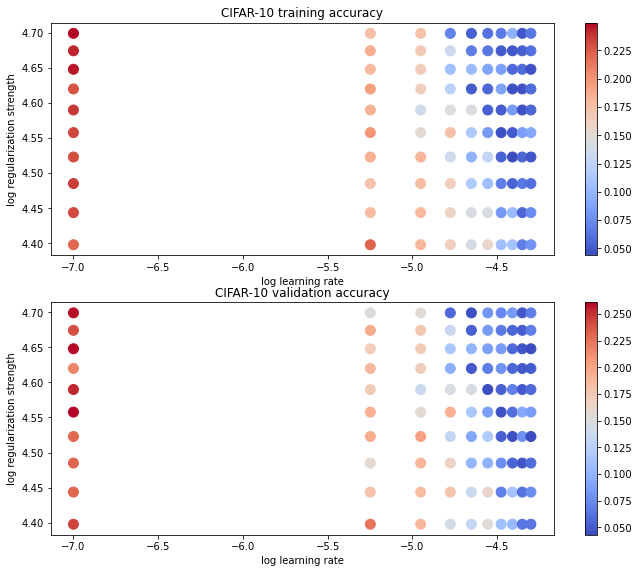

In [82]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [84]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.372000


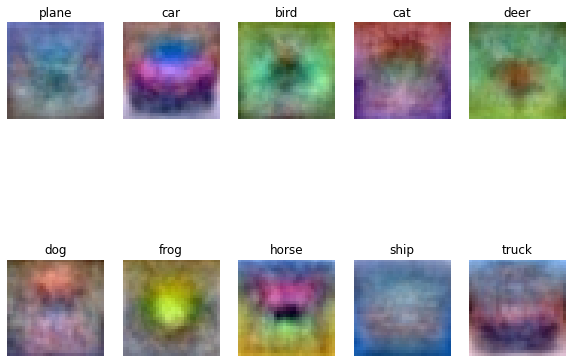

In [85]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
